In [ ]:
!pip install gdown
!FILE=./Data/previous_application.csv;if test -f "$FILE"; then;echo "$FILE exists.";else gdown https://drive.google.com/uc\?id\=1vrz6POC4ZXsXoS3lmzr16zuFHhZWRiOb -O ./Data/previous_application.csv; fi
!FILE=./Data/application_train.csv;if test -f "$FILE"; then;echo "$FILE exists.";else gdown https://drive.google.com/uc\?id\=1onNfyrOlMKwb3Bx2L6Gi1Kwz9ow1S236 -O ./Data/application_train.csv; fi
!FILE=./Data/application_test.csv;if test -f "$FILE"; then;echo "$FILE exists.";else gdown https://drive.google.com/uc\?id\=1lbOWxUovZVT-biRd-NYBn4jadxiJxxkq -O ./Data/application_test.csv; fi 

In [1]:
import warnings
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, log_loss, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option("display.max_colwidth",200)
pd.options.display.float_format = '{:,.2f}'.format
warnings.filterwarnings('ignore')
default_dir = './Data'

<h1 align="center"> Previous Application Table </h1>

### Mô tả dữ liệu:
- Dữ liệu gồm tất cả các đơn đăng ký vay Home Credit trước đây của các khách hàng đã vay trong kho dữ liệu của Home Credit cung cấp. 
- Mỗi dòng tương ứng cho một đơn đăng ký vay và khách hàng có thể nằm hoặc không trong tập dữ liệu đã báo cáo cho Phòng Tín Dụng

In [2]:
prev_app_df = pd.read_csv('./Data/previous_application.csv')
prev_app_df.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,"1,730.43","17,145.00","17,145.00",0.00,"17,145.00",SATURDAY,15,Y,1,0.00,0.18,0.87,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.00,middle,POS mobile with interest,"365,243.00",-42.00,300.00,-42.00,-37.00,0.00
1,2802425,108129,Cash loans,"25,188.62","607,500.00","679,671.00",NaN,"607,500.00",THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.00,low_action,Cash X-Sell: low,"365,243.00",-134.00,916.00,"365,243.00","365,243.00",1.00
2,2523466,122040,Cash loans,"15,060.74","112,500.00","136,444.50",NaN,"112,500.00",TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.00,high,Cash X-Sell: high,"365,243.00",-271.00,59.00,"365,243.00","365,243.00",1.00
3,2819243,176158,Cash loans,"47,041.33","450,000.00","470,790.00",NaN,"450,000.00",MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.00,middle,Cash X-Sell: middle,"365,243.00",-482.00,-152.00,-182.00,-177.00,1.00
4,1784265,202054,Cash loans,"31,924.40","337,500.00","404,055.00",NaN,"337,500.00",THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.00,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


# 1. Explode Data Analysis

## 1.1 Dữ liệu có bao nhiêu dòng và cột

In [3]:
print(f'Dữ liệu có {prev_app_df.shape[0]} dòng')
print(f'Dữ liệu có {prev_app_df.shape[1]} cột')

Dữ liệu có 1670214 dòng
Dữ liệu có 37 cột


## 1.2 Dữ liệu có bị trùng lặp không ?

In [4]:
prev_app_df.duplicated().sum()

0

## 1.3 Kiểu dữ liệu có gì bất thường không ?

In [5]:
prev_app_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

**Nhận xét**
- Dữ liệu chứa giá trị 'XNA' tương đương NaN
- Các thuộc tính còn lại không có gì bất thường về kiểu dữ liệu và giá trị.

### Tiền xử lý giá trị XNA và thống kê giá trị thiếu

In [6]:
# Số dòng có ít nhất 1 giá trị là XNA
print(f"Dữ liệu Rrevious Application có {(prev_app_df == 'XNA').any(axis = 1).sum()} dòng chứa giá trị XNA")

# Thay thế XNA bằng NaN
prev_app_df.replace('XNA', np.nan, inplace=True)

Dữ liệu Rrevious Application có 1670214 dòng chứa giá trị XNA


In [7]:
# thống kế số lượng giá trị thiếu của từng cột
def missing_value_table(df): 
    miss_val = df.isnull().sum()
        
    miss_val_percent = 100 * df.isnull().sum() / len(df)

    miss_val_table = pd.concat([miss_val, miss_val_percent], axis=1)

    miss_val_table.rename(columns = {0 : 'Missing Values', 
                                    1 : '% of Total Values'}, 
                         inplace=True)

    return miss_val_table

missing_value_stats = missing_value_table(prev_app_df)
sort_missing_value_stats = missing_value_stats.sort_values('Missing Values',ascending=False)

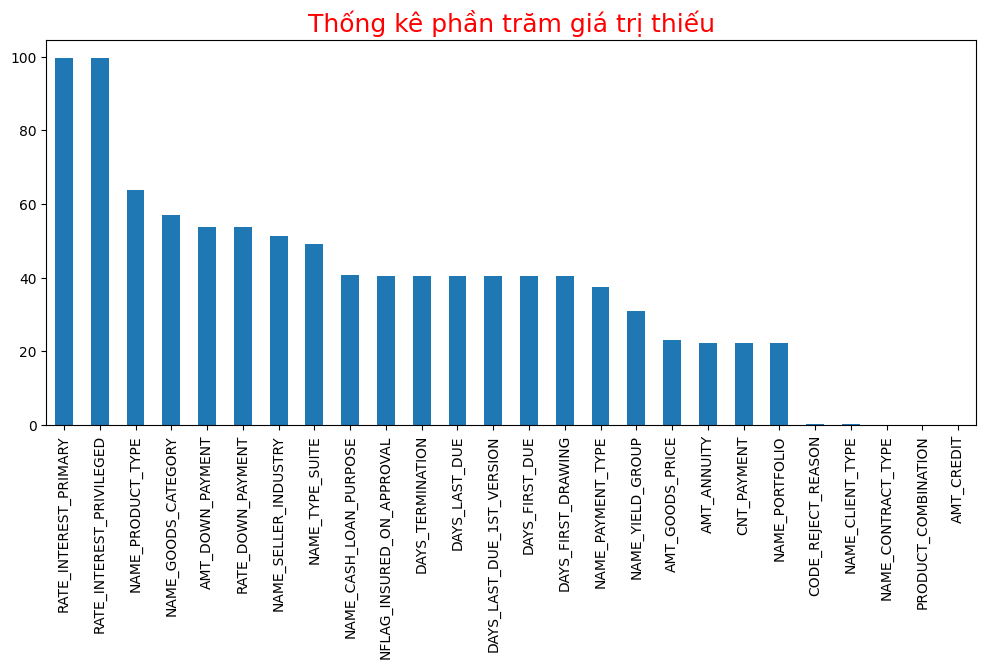

In [8]:
# trực quan hóa phần số lượng giá trị thiếu
plt.rcParams['figure.figsize'] = (12,5)
sort_missing_value_stats.loc[sort_missing_value_stats['% of Total Values'] > 0, '% of Total Values'].plot.bar()

plt.title("Thống kê phần trăm giá trị thiếu", fontsize = 18, color = 'r')

plt.show()

**Nhận xét**: Nhóm chia mức độ thiếu dữ liệu thành 3 nhóm và đề xuất phương pháp xử  lý cho từng nhóm:
- Các thuộc tính bị thiếu dữ liệu trên 99% như `RATE_INTEREST_PRIMARY` và `RATE_INTEREST_PRIVILEGED`  $\rightarrow$ nhóm sẽ xem xét xóa cột này.
- Các thuộc tính bị thiếu trên 50%  $\rightarrow$ nhóm sẽ dùng cái phương pháp thông kê để điền giá trị thiếu.
- Nhưng thuộc tính còn lại xấp xỉ 0% $\rightarrow$ nhóm sẽ xem xét bỏ những dòng mà giá trị này thiếu hoặc sẽ giữ nguyên.

**Nhóm sẽ phân tích kỹ hơn từng thuộc tính**

## 1.4 Phân tích thuộc tính category
**Note**: Phần tiếp theo nhóm chủ yếu phân tích để phát hiện những mâu thuẫn trong dữ liệu, mục đích cuối là hiểu rõ hơn về hành vi và thói quen của khách hàng để xử lý Time Series và chuẩn hóa dữ liệu hiệu quả ở giai đoạn sau.

In [9]:
category_prev_app_df = prev_app_df.select_dtypes('O')
category_prev_app_df.head(5)

,NAME_CONTRACT_TYPE,WEEKDAY_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PRODUCT_COMBINATION
0,Consumer loans,SATURDAY,Y,XAP,Approved,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,NaN,Country-wide,Connectivity,middle,POS mobile with interest
1,Cash loans,THURSDAY,Y,NaN,Approved,NaN,XAP,Unaccompanied,Repeater,NaN,Cash,x-sell,Contact center,NaN,low_action,Cash X-Sell: low
2,Cash loans,TUESDAY,Y,NaN,Approved,Cash through the bank,XAP,"Spouse, partner",Repeater,NaN,Cash,x-sell,Credit and cash offices,NaN,high,Cash X-Sell: high
3,Cash loans,MONDAY,Y,NaN,Approved,Cash through the bank,XAP,NaN,Repeater,NaN,Cash,x-sell,Credit and cash offices,NaN,middle,Cash X-Sell: middle
4,Cash loans,THURSDAY,Y,Repairs,Refused,Cash through the bank,HC,NaN,Repeater,NaN,Cash,walk-in,Credit and cash offices,NaN,high,Cash Street: high


In [10]:
category_prev_app_df[category_prev_app_df['NAME_TYPE_SUITE'] == 'Spouse']

,NAME_CONTRACT_TYPE,WEEKDAY_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PRODUCT_COMBINATION


In [11]:
# thống kê giá trị từng cột
category_prev_app_df.agg([pd.Series.unique, pd.Series.nunique]).T

,unique,nunique
NAME_CONTRACT_TYPE,"[Consumer loans, Cash loans, Revolving loans, nan]",3
WEEKDAY_APPR_PROCESS_START,"[SATURDAY, THURSDAY, TUESDAY, MONDAY, FRIDAY, SUNDAY, WEDNESDAY]",7
FLAG_LAST_APPL_PER_CONTRACT,"[Y, N]",2
NAME_CASH_LOAN_PURPOSE,"[XAP, nan, Repairs, Everyday expenses, Car repairs, Building a house or an annex, Other, Journey, Purchase of electronic equipment, Medicine, Payments on other loans, Urgent needs, Buying a used c...",24
NAME_CONTRACT_STATUS,"[Approved, Refused, Canceled, Unused offer]",4
NAME_PAYMENT_TYPE,"[Cash through the bank, nan, Non-cash from your account, Cashless from the account of the employer]",3
CODE_REJECT_REASON,"[XAP, HC, LIMIT, CLIENT, SCOFR, SCO, nan, VERIF, SYSTEM]",8
NAME_TYPE_SUITE,"[nan, Unaccompanied, Spouse, partner, Family, Children, Other_B, Other_A, Group of people]",7
NAME_CLIENT_TYPE,"[Repeater, New, Refreshed, nan]",3
NAME_GOODS_CATEGORY,"[Mobile, nan, Consumer Electronics, Construction Materials, Auto Accessories, Photo / Cinema Equipment, Computers, Audio/Video, Medicine, Clothing and Accessories, Furniture, Sport and Leisure, Ho...",27


### 1.4.1 NAME_CONTRACT_TYPE vs NAME_CONTRACT_STATUS

**Mô tả dữ liệu**: 
- `NAME_CONTRACT_TYPE` có 3 giá trị chính:
    - Revolving loans (credit card): Người đi vay được cập một hạn mức tín dụng, người đó có thể chi tiêu/rút tiền với hạn mức tín dụng đó. Và cuối tháng thì ngân hàng sẽ thông báo khoản vay tối thiểu mà người đó phải trả.
    - Consumer loans (Point of Sale - POS): Người vay được cấp một hạn mức tín dụng để mua hàng hóa và sẽ phải hoàn trả khoản tín dụng đó hàng tháng, mỗi tháng cách nhau 30 ngày.
    - Cash loans: Người xin vay được cấp một khoản tiền mặt để có thể chi tiêu và sẽ cần hoàn trả khoản tín dụng đó hàng tháng, mỗi tháng cách nhau 30 ngày.
- `NAME_CONTRACT_STATUS`: 
    - Thể hiện trạng thái của hồ sơ như Approved hoặc Refused hoặc Canceled.
    - Trạng thái hồ sơ có thể là Unused offer nếu khách hàng chưa sử dụng tín dụng

Nguồn tham khảo: https://www.kaggle.com/c/home-credit-default-risk/discussion/63032

### Tỷ lệ phần trăm từng giá trị của contract type và contract status

In [12]:
name_contract_type_stats = category_prev_app_df['NAME_CONTRACT_TYPE'].value_counts(dropna=False)
name_contract_status_stats = category_prev_app_df['NAME_CONTRACT_STATUS'].value_counts(dropna=False)

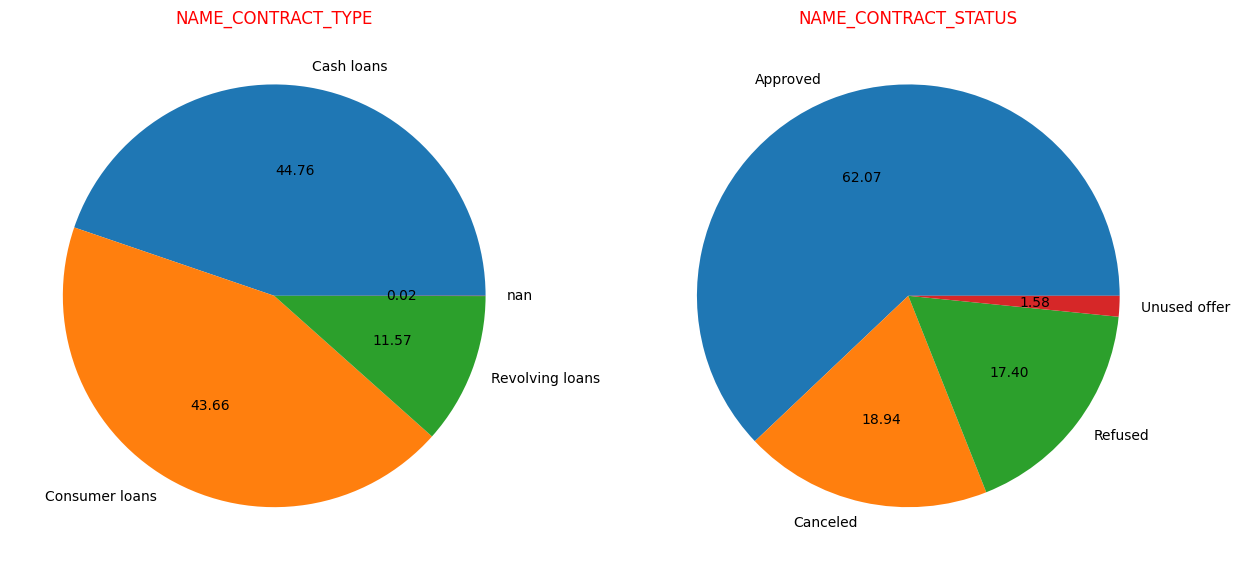

In [13]:
# Trực quan hóa
fig, ax = plt.subplots(1,2, figsize = (15,8))
ax[0].pie(name_contract_type_stats.values, labels=name_contract_type_stats.index, autopct='%.2f')
ax[0].set_title('NAME_CONTRACT_TYPE', fontsize =12, color='r')
ax[1].pie(name_contract_status_stats.values, labels=name_contract_status_stats.index, autopct='%.2f')
ax[1].set_title('NAME_CONTRACT_STATUS', fontsize =12, color='r')

plt.show()

**Nhận xét**:
- Loại hợp đồng chủ yếu là `Cash loan` và `Consumer loan`. Các khoản vay bị thiếu thông tin loại hợp đồng chiếm tỷ lệ nhỏ, không đáng kể.
- Hồ sơ có trạng thái `Approved` chiếm tỷ lệ cao nhất. `Unused offer` chiếm tỷ lệ không đáng kể.

### So sánh tỷ lệ của contract status theo contract type của khách hàng trong quá khứ

In [14]:
groupby_contract_df = category_prev_app_df.groupby(['NAME_CONTRACT_STATUS', 
                                                    'NAME_CONTRACT_TYPE'])[['NAME_CONTRACT_TYPE']].count()
groupby_contract_df.rename(columns={'NAME_CONTRACT_TYPE': 'COUNT'}, inplace=True)

In [15]:
# unstack NAME_CONTRACT_STATUS
groupby_contract_df = groupby_contract_df.unstack(level=1)['COUNT'].T
groupby_contract_df

NAME_CONTRACT_STATUS,Approved,Canceled,Refused,Unused offer
NAME_CONTRACT_TYPE,,,,
Cash loans,312540,268591,165928,494
Consumer loans,626470,1559,75185,25937
Revolving loans,97771,45854,49534,5


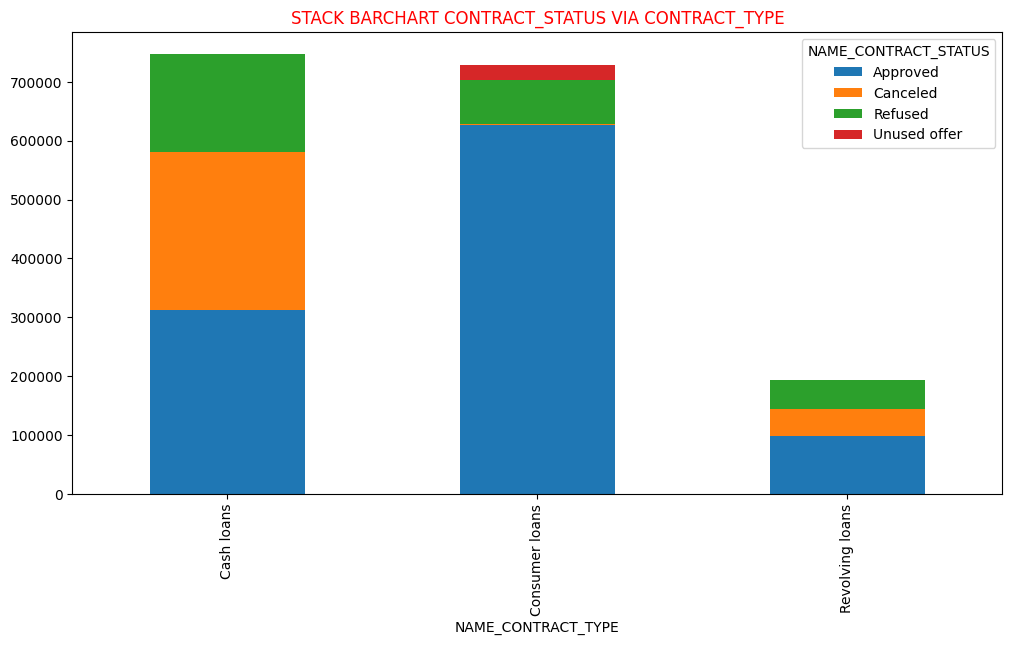

In [16]:
## Trực quan hóa
plt.rcParams['figure.figsize'] = (12,6)
groupby_contract_df.plot(kind='bar', stacked=True);
plt.title("STACK BARCHART CONTRACT_STATUS VIA CONTRACT_TYPE", fontsize=12 ,color='r');

**Nhận xét**:
- Qua stack barchart thì có cái nhìn chi tiết hơn, cụ thể:
    - Số lượng đơn `Approved` vẫn chiếm tỉ lệ cao, đặc biệt đối với `Consumer loans`.
    - Số lượng đơn `Refused` chủ yếu đến từ `Cash loans` là chính và đáng chú ý là `Cash loans` có số lượng đơn `Refused` và `Canceled` cao bất thường.
    - Số lượng `Unused offer` đa số đến từ `Comsumer loans`, có thể đây là đến từ thói quen của khách hàng.

### So sánh tỷ lệ contract type và contract status của đơn vay gần nhất  với đơn vay trước đó.
**Note**: Nhóm muốn phân tích nhu cầu gần nhất của khách hàng, phân tích trạng thái đơn hoặc loại hình vay trước đó của nhóm khách hàng quay trở lại có sự thay đổi hay không ?

In [17]:
groupby_target_contract_df = category_prev_app_df.groupby(['NAME_CONTRACT_STATUS', 
                                                         'NAME_CONTRACT_TYPE',
                                                         'FLAG_LAST_APPL_PER_CONTRACT'])

In [18]:
groupby_target_contract_df = groupby_target_contract_df[['FLAG_LAST_APPL_PER_CONTRACT']].count()
groupby_target_contract_df.rename(columns={'FLAG_LAST_APPL_PER_CONTRACT': 'COUNT'}, inplace=True)

In [19]:
# unstack FLAG_LAST_APPL_PER_CONTRACT
groupby_target_contract_df = groupby_target_contract_df.unstack(level=2)                                                   

In [20]:
# unstack NAME_CONTRACT_STATUS
groupby_target_contract_df = groupby_target_contract_df['COUNT'].unstack(level=1).T
groupby_target_contract_df

NAME_CONTRACT_STATUS                             Approved   Canceled   
FLAG_LAST_APPL_PER_CONTRACT NAME_CONTRACT_TYPE                         
N                           Cash loans                NaN        NaN  \
                            Consumer loans            NaN        NaN   
                            Revolving loans           NaN       2.00   
Y                           Cash loans         312,540.00 268,591.00   
                            Consumer loans     626,470.00   1,559.00   
                            Revolving loans     97,771.00  45,852.00   

NAME_CONTRACT_STATUS                              Refused  Unused offer  
FLAG_LAST_APPL_PER_CONTRACT NAME_CONTRACT_TYPE                           
N                           Cash loans               4.00           NaN  
                            Consumer loans            NaN           NaN  
                            Revolving loans      8,469.00           NaN  
Y                           Cash loans         165,924.00        494.00  
                            Consumer loans      75,185.00     25,937.00  
                            Revolving loans     41,065.00          5.00

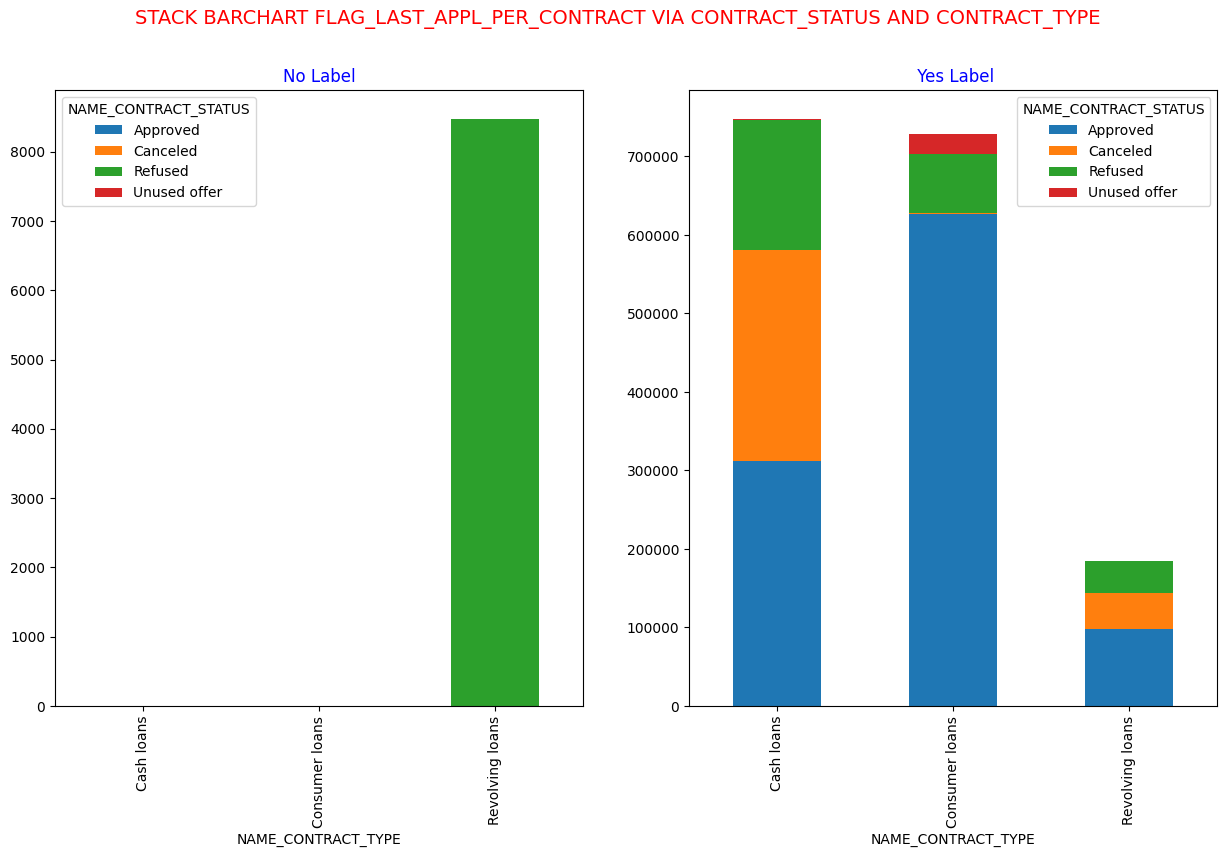

In [21]:
# Trực quan hóa target = No
fig, ax = plt.subplots(1,2, figsize = (15,8))
groupby_target_contract_df.loc['N'].plot(kind='bar', stacked=True ,ax = ax[0]);
ax[0].set_title('No Label',fontsize=12,color='b')

# Trực quan hóa target = Yes
groupby_target_contract_df.loc['Y'].plot(kind='bar', stacked=True, ax=ax[1]);
ax[1].set_title(' Yes Label',fontsize=12,color='b')

plt.suptitle("STACK BARCHART FLAG_LAST_APPL_PER_CONTRACT VIA CONTRACT_STATUS AND CONTRACT_TYPE", fontsize=14,color='r');

**Nhận xét**: Kết hợp với stack barchart ở 2 phần trên thì có cái nhìn cụ thể hơn:
- Nhóm đơn vay trước đó đa số đăng ký `Revolving loans` và status là `Refused` $\rightarrow$ Nên làm rõ hơn vì sao ở đây tỷ lệ từ chối lại cao như vậy. 
- Còn lại phân bố đơn vay gần nhất thì nhìn chung tương tự ở phần trước.
    - Nên cân nhắc thuộc tính `FLAG_LAST_APPL_PER_CONTRACT` vì có sự chênh lệch lớn theo `NAME_CONTRACT_TYPE` và `NAME_CONTRACT_STATUS` $\rightarrow$ Điều này có thể dẫn đến bias khi đưa vào mô hình học máy.

### 1.4.2 NAME_CASH_LOAN_PURPOSE 

**Nhận xét**:
- Xem xét trường thuộc tính `NAME_CASH_LOAN_PURPOSE` ngoài giá trị NaN thì có 2 values đáng để ý là `Refusal to name the goal` và `Payments on other loans`. 
- Nhóm sẽ thống kê dựa trên `FLAG_LAST_APPL_PER_CONTRACT(TARGET), NAME_CONTRACT_STATUS` để xem có điều gì bất thường hay không ? Liệu rằng có xuất hiện cách thức vay vốn xoay vòng ở đây ?

In [22]:
obs_loan_purpose_df = category_prev_app_df[category_prev_app_df['NAME_CASH_LOAN_PURPOSE'].isin(['Refusal to name the goal',
                                                                                                'Payments on other loans'])]
groupby_obs_lpur_df = obs_loan_purpose_df[['FLAG_LAST_APPL_PER_CONTRACT', 
                                           'NAME_CONTRACT_STATUS', 
                                           'NAME_CASH_LOAN_PURPOSE']]
groupby_obs_lpur_df = groupby_obs_lpur_df.groupby(['FLAG_LAST_APPL_PER_CONTRACT', 
                                                   'NAME_CONTRACT_STATUS', 
                                                   'NAME_CASH_LOAN_PURPOSE'])

In [23]:
groupby_obs_lpur_df = groupby_obs_lpur_df[['FLAG_LAST_APPL_PER_CONTRACT']].count()
groupby_obs_lpur_df.rename(columns={'FLAG_LAST_APPL_PER_CONTRACT': 'COUNT'}, inplace=True)

In [24]:
# unstack FLAG_LAST_APPL_PER_CONTRACT
groupby_obs_lpur_df = groupby_obs_lpur_df.unstack(level=0)

In [25]:
# unstack NAME_CONTRACT_STATUS
groupby_obs_lpur_df = groupby_obs_lpur_df['COUNT'].unstack(level=1)['Y']
groupby_obs_lpur_df

NAME_CASH_LOAN_PURPOSE,Payments on other loans,Refusal to name the goal
NAME_CONTRACT_STATUS,,
Approved,304.00,4.00
Canceled,70.00,NaN
Refused,"1,553.00",11.00
Unused offer,4.00,NaN


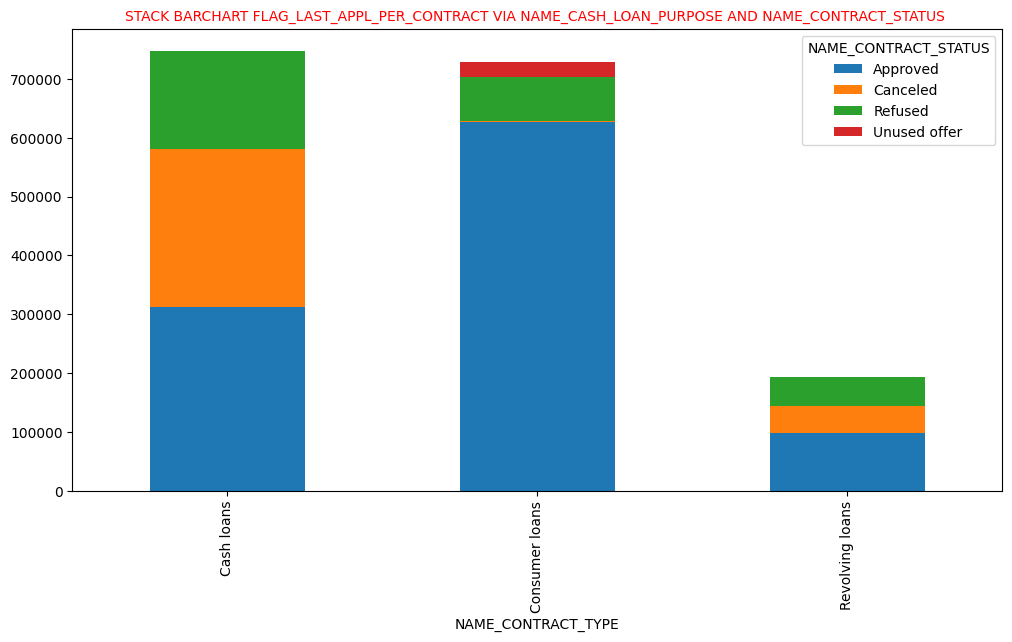

In [26]:
## Trực quan hóa
plt.rcParams['figure.figsize'] = (12,6)
groupby_contract_df.plot(kind='bar', stacked=True);
plt.title("STACK BARCHART FLAG_LAST_APPL_PER_CONTRACT VIA NAME_CASH_LOAN_PURPOSE AND NAME_CONTRACT_STATUS ", fontsize=10 ,color='r');

**Nhận xét**:
- Các khoản vay có mục đích là `Refusal to name the goal và Payments on other loans` thì đều thuộc vào giao dịch gần nhất của hợp đồng và tỷ lệ phân bố `NAME_CONTRACT_STATUS` tương tự phần ở trên. $\rightarrow$ không phát hiện điểm bất thường hay gian lận của khách hàng ở đây.

### 1.4.3 WEEKDAY_APPR_PROCESS_START vs HOUR_APPR_PROCESS_START

**Mô tả dữ liệu**:
- `WEEKDAY_APPR_PROCESS_START`: Ngày nào trong tuần khách hàng bắt đầu quy trình đăng ký khoản vay.

- `HOUR_APPR_PROCESS_START`: Khoảng giờ bắt đầu quá trình đăng ký khoản vay.

In [27]:
weekday_app_stats = category_prev_app_df['WEEKDAY_APPR_PROCESS_START'].value_counts(dropna=False)
hour_app_stats = prev_app_df['HOUR_APPR_PROCESS_START'].value_counts(dropna=False).sort_index()

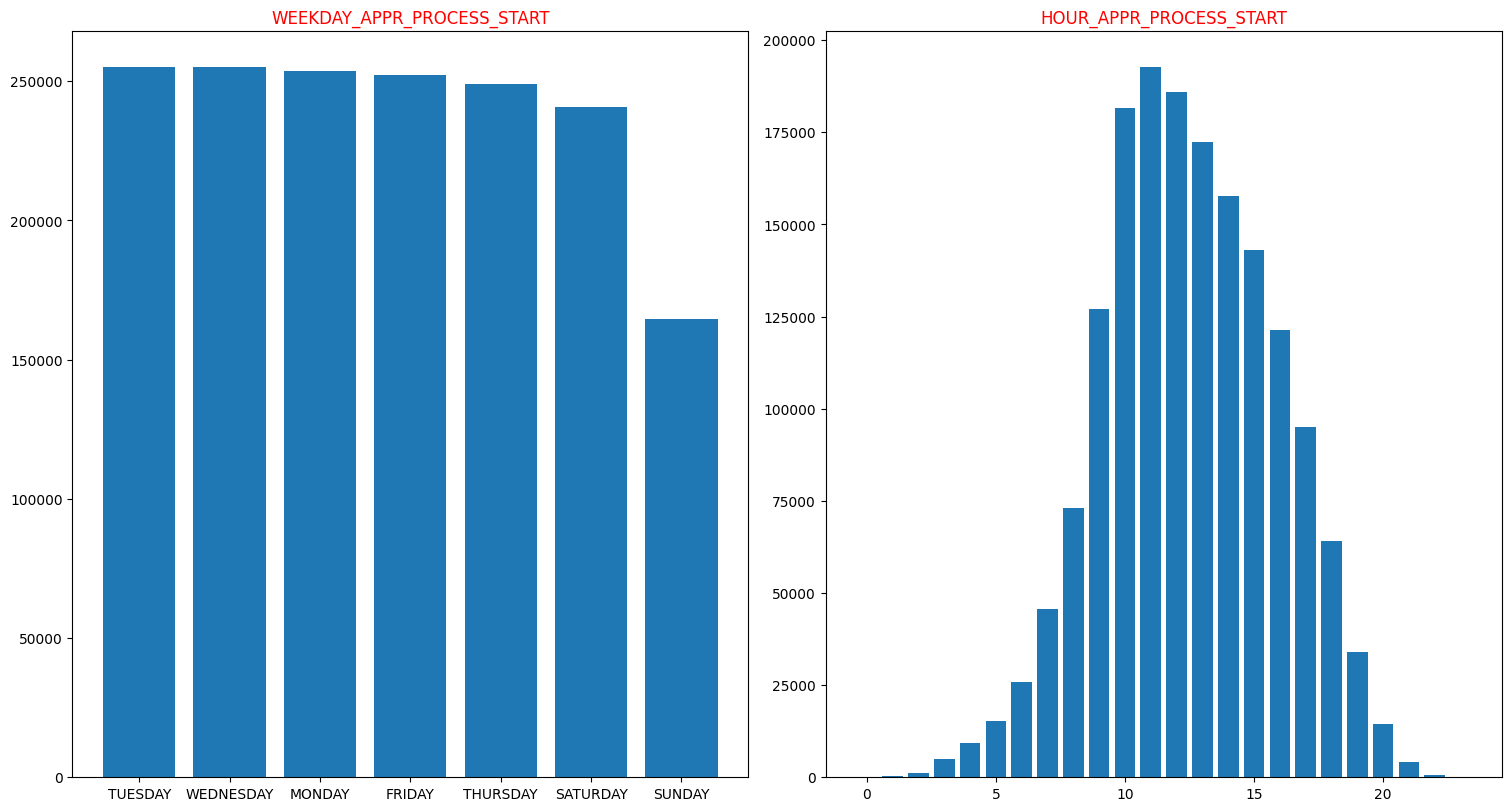

In [28]:
# Trực quan hóa
fig, ax = plt.subplots(1,2, figsize = (15,8), layout="constrained")
ax[0].bar(weekday_app_stats.index, height=weekday_app_stats.values)
ax[0].set_title('WEEKDAY_APPR_PROCESS_START', fontsize =12, color='r')
ax[1].bar(hour_app_stats.index, height=hour_app_stats.values)
ax[1].set_title('HOUR_APPR_PROCESS_START', fontsize =12, color='r')
plt.show()

**Nhận xét**
- Khách hàng bắt đầu quy trình đăng ký khoản vay vào hầu hết các ngày trong tuần, chỉ riêng Chủ Nhật thì thấp hơn.
- Thời gian khách hàng bắt đầu thì tập trung chủ yếu vào khoảng thời gian từ 9h-17h

## 1.5 Phân tích thuộc tính numeric

**Note**: 
- Phần tiếp theo nhóm chủ yếu phân tích phân bố của dữ liệu để tìm những điểm outlier và đánh giá chất lượng bộ dữ liệu.
- Không sử dụng các thuộc tính `SK_ID_PREV` `SK_ID_CURR` vì đây là dãy số đã qua thuật toán hashing của Home Credit.
- Không sử dụng thuộc tính `SELLERPLACE_AREA` vì thuộc tính này được mã hóa từ thuộc tính category.
- Không sử dụng các thuộc tính `RATE_DOWN_PAYMENT` , `RATE_DOWN_PAYMENT`, `RATE_INTEREST_PRIVILEGED` vì bị thiếu quá nhiều giá trị (lên tới 99%).

In [29]:
numeric_prev_app_df = prev_app_df.select_dtypes(['int64','float64']).drop(columns=['SK_ID_PREV', 'SK_ID_CURR'])
numeric_prev_app_df.head()

,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,"1,730.43","17,145.00","17,145.00",0.00,"17,145.00",15,1,0.00,0.18,0.87,-73,35,12.00,"365,243.00",-42.00,300.00,-42.00,-37.00,0.00
1,"25,188.62","607,500.00","679,671.00",NaN,"607,500.00",11,1,NaN,NaN,NaN,-164,-1,36.00,"365,243.00",-134.00,916.00,"365,243.00","365,243.00",1.00
2,"15,060.74","112,500.00","136,444.50",NaN,"112,500.00",11,1,NaN,NaN,NaN,-301,-1,12.00,"365,243.00",-271.00,59.00,"365,243.00","365,243.00",1.00
3,"47,041.33","450,000.00","470,790.00",NaN,"450,000.00",7,1,NaN,NaN,NaN,-512,-1,12.00,"365,243.00",-482.00,-152.00,-182.00,-177.00,1.00
4,"31,924.40","337,500.00","404,055.00",NaN,"337,500.00",9,1,NaN,NaN,NaN,-781,-1,24.00,NaN,NaN,NaN,NaN,NaN,NaN


### 1.5.1 AMT columns
**Mô tả dữ liệu**: gồm các thông tin liên quan đến tiền và chính sách của ngân hàng
- **AMT_ANNUITY**: số tiền phải trả hằng tháng(bao gồm cả lãi). Khách hàng có thể thay đổi Annuity trong `Balance` và `Payments` tables. 
- **AMT_APPLICATION**: khách hàng đã yêu cầu tín dụng bao nhiêu trong lần đăng ký trước tín dụng.
- **AMT_GOODS_PRICE**: giá của hàng hóa. 
- **AMT_CREDIT**: số tiền thực tế mà khách hàng nhận được, có thể cao hoặc thấp hơn dựa vào chế độ bảo hiểm hoặc chính sách của Home Credit.
    - AMT_CREDIT = AMT_GOODS_PRICE + tiền bảo hiểm 
    - NFLAG_INSURED_ON_APPROVAL liên quan đến một trong những tùy chon bảo hiểm mà Home Credit cung cấp
- **AMT_DOWN_PAYMENT**: khoản tiền mà khách hàng phải tự thanh toán đổi với `Consumer loans` và số tiền còn lại sẽ do Home Credit chi trả. Đối với `Revolving loans` và `Cash loans` thì giá trị này bằng 0 hoặc bị bỏ trống. 

In [30]:
def missing_ratio(column):
    return (column.isna().mean() * 100).round(2)

def lower_quantile(column):
    return column.quantile(q= 0.25)

def upper_quantile(column):
    return column.quantile(q= 0.75)

In [31]:
amt_prev_app_df = prev_app_df[['AMT_ANNUITY', 'AMT_APPLICATION','AMT_CREDIT', 
                               'AMT_DOWN_PAYMENT','AMT_GOODS_PRICE']]
amt_prev_app_df.agg([missing_ratio, min, lower_quantile, np.median, upper_quantile, max, np.std])

,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE
missing_ratio,22.29,0.00,0.00,53.64,23.08
min,0.00,0.00,0.00,-0.90,0.00
lower_quantile,"6,321.78","18,720.00","24,160.50",0.00,"50,841.00"
median,"11,250.00","71,046.00","80,541.00","1,638.00","112,320.00"
upper_quantile,"20,658.42","180,360.00","216,418.50","7,740.00","234,000.00"
max,"418,058.15","6,905,160.00","6,905,160.00","3,060,045.00","6,905,160.00"
std,"14,782.14","292,779.76","318,574.62","20,921.50","315,396.56"


**Nhận xét**: 
- Thuộc tính `AMT_DOWN_PAYMENT` xuất hiện giá trị âm $\rightarrow$ điểm bất thường
- Các thuộc tính xuất hiện giá trị 0 $\rightarrow$ dựa vào `NAME_CONTRACT_TYPE` và `AMT_DOWN_PAYMENT` thì giá trị có thể bằng 0.
    - AMT_APPLICATION = 0 đây là giao dịch đầu tiên của một khách hàng.
    - AMT_ANNUITY = 0 chứng tỏ khách hàng trả hết khoảng vay trong một lần.
- Dữ liệu có độ lệch chuẩn tương đối cao, nhóm sẽ dựa vào phân bố để xác định có tồn tại outlier hay không ?

### Tiền xử lý AMT_DOWN_PAYMENT

In [32]:
prev_app_df[prev_app_df['AMT_DOWN_PAYMENT'] < 0]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
368107,1284109,350530,Consumer loans,"7,866.09","71,580.60","71,581.50",-0.90,"71,580.60",SATURDAY,13,Y,1,-0.00,NaN,NaN,XAP,Approved,-508,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,NaN,Country-wide,45,Connectivity,10.00,low_normal,POS mobile without interest,"365,243.00",-459.00,-189.00,-189.00,-185.00,0.00
1519595,1817983,133068,Consumer loans,"3,595.55","32,719.05","32,719.50",-0.45,"32,719.05",SUNDAY,13,Y,1,-0.00,NaN,NaN,XAP,Approved,-478,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,NaN,Country-wide,45,Connectivity,10.00,low_normal,POS mobile without interest,"365,243.00",-430.00,-160.00,-430.00,-415.00,0.00


**Nhận xét**: 
- Khoản tiền trả trước (`AMT_DOWN_PAYMENT`) sẽ có nhiều hạn mức khác nhau theo loại hàng hóa $\rightarrow$ những giao dịch này là outlier.
- Nhóm sẽ xóa những dòng này

In [33]:
prev_app_df = prev_app_df[~(prev_app_df['AMT_DOWN_PAYMENT'] < 0)]

### Tiếp tục khám phá phân bố thuộc tính numeric 

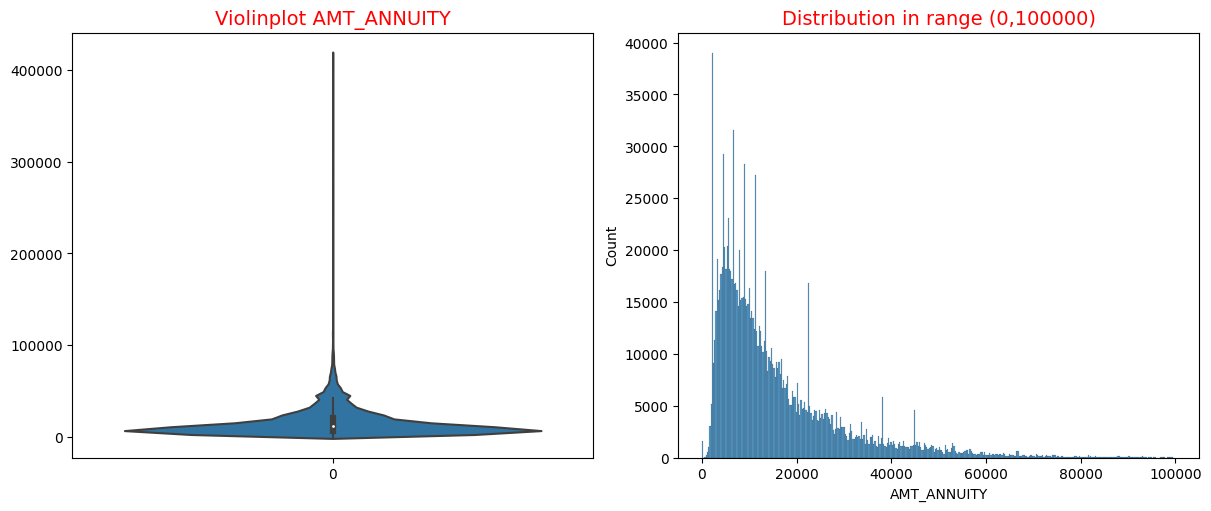

In [34]:
fig, ax = plt.subplots(1,2, figsize = (12,5), layout="constrained")
sns.violinplot(prev_app_df['AMT_ANNUITY'], ax = ax[0])
sns.histplot(prev_app_df['AMT_ANNUITY'], ax = ax[1], 
             binrange=(0,100000))
ax[0].set_title('Violinplot AMT_ANNUITY', fontsize = 14, color='r')
ax[1].set_title('Distribution in range (0,100000)', fontsize = 14, color='r')
plt.show()

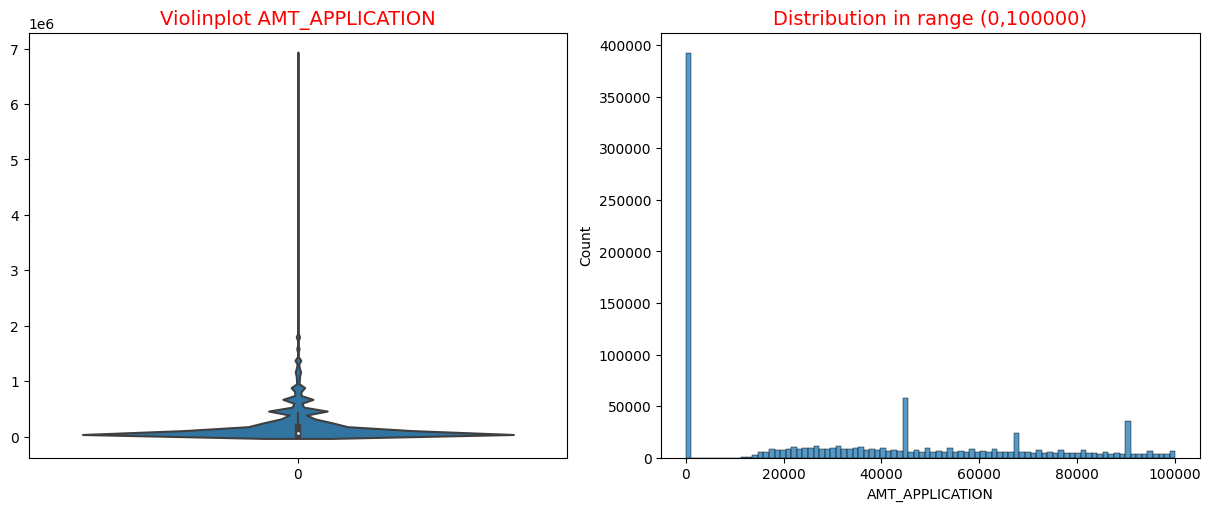

In [35]:
fig, ax = plt.subplots(1,2, figsize = (12,5), layout="constrained")
sns.violinplot(prev_app_df['AMT_APPLICATION'], ax = ax[0])
sns.histplot(prev_app_df['AMT_APPLICATION'], ax = ax[1], 
             binrange=(0,100000))
ax[0].set_title('Violinplot AMT_APPLICATION', fontsize = 14, color='r')
ax[1].set_title('Distribution in range (0,100000)', fontsize = 14, color='r')
plt.show()

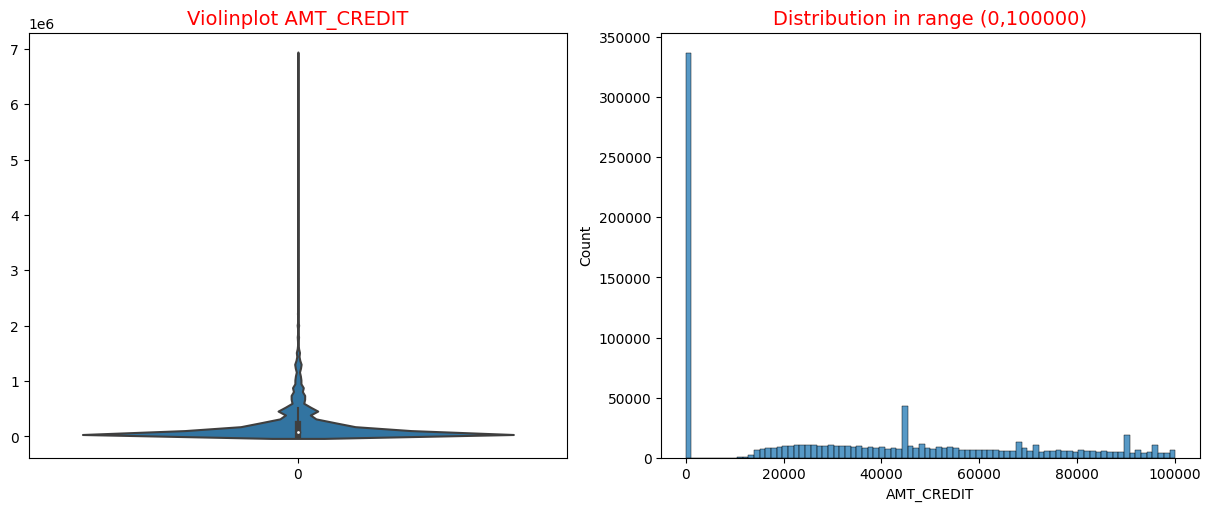

In [36]:
fig, ax = plt.subplots(1,2, figsize = (12,5), layout="constrained")
sns.violinplot(prev_app_df['AMT_CREDIT'], ax = ax[0])
sns.histplot(prev_app_df['AMT_CREDIT'], ax = ax[1], 
             binrange=(0,100000))
ax[0].set_title('Violinplot AMT_CREDIT', fontsize = 14, color='r')
ax[1].set_title('Distribution in range (0,100000)', fontsize = 14, color='r')
plt.show()

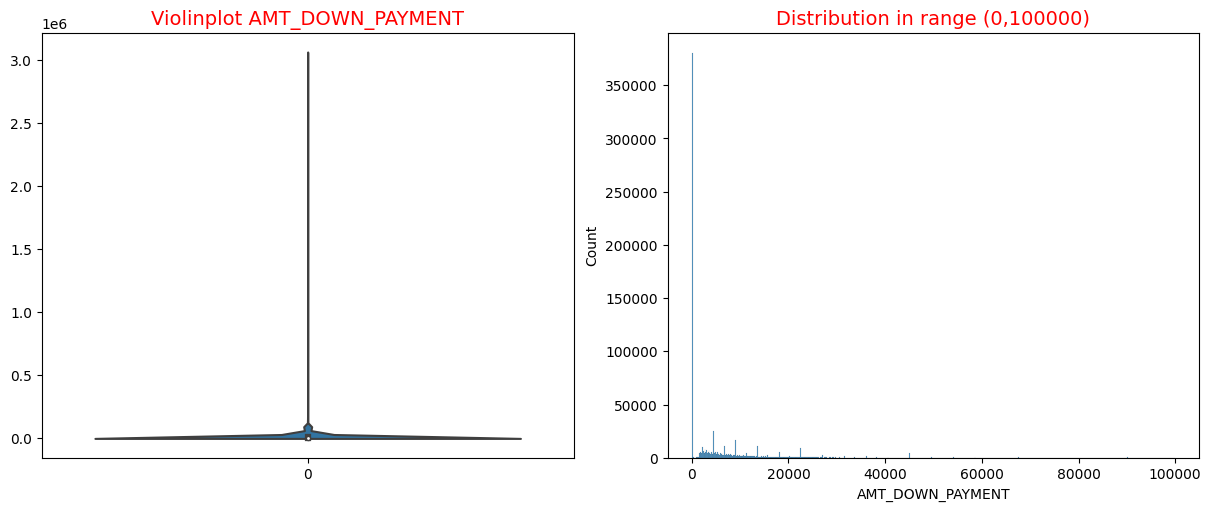

In [37]:
fig, ax = plt.subplots(1,2, figsize = (12,5), layout="constrained")
sns.violinplot(prev_app_df['AMT_DOWN_PAYMENT'], ax = ax[0])
sns.histplot(prev_app_df['AMT_DOWN_PAYMENT'], ax = ax[1], 
             binrange=(0,100000))
ax[0].set_title('Violinplot AMT_DOWN_PAYMENT', fontsize = 14, color='r')
ax[1].set_title('Distribution in range (0,100000)', fontsize = 14, color='r')
plt.show()

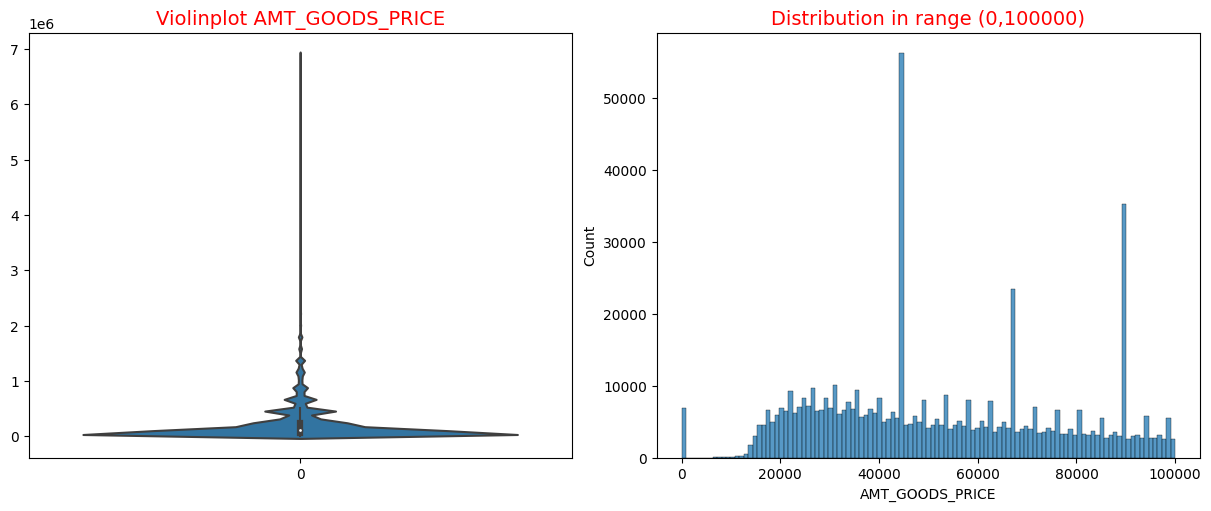

In [38]:
fig, ax = plt.subplots(1,2, figsize = (12,5), layout="constrained")
sns.violinplot(prev_app_df['AMT_GOODS_PRICE'], ax = ax[0])
sns.histplot(prev_app_df['AMT_GOODS_PRICE'], ax = ax[1], 
             binrange=(0,100000))
ax[0].set_title('Violinplot AMT_GOODS_PRICE', fontsize = 14, color='r')
ax[1].set_title('Distribution in range (0,100000)', fontsize = 14, color='r')
plt.show()

**Nhận xét**
- Các thuộc tính đều có phân bố lệch phải.
- `AMT_APPLICATION, AMT_CREDIT, AMT_DOWN_PAYMENT` có giá trị 0 chiếm số lượng lớn trong thuộc tính này.
- Không có điểm bất thường ở đây

### Trực quan hóa các thuộc tính ATM bằng pairplot

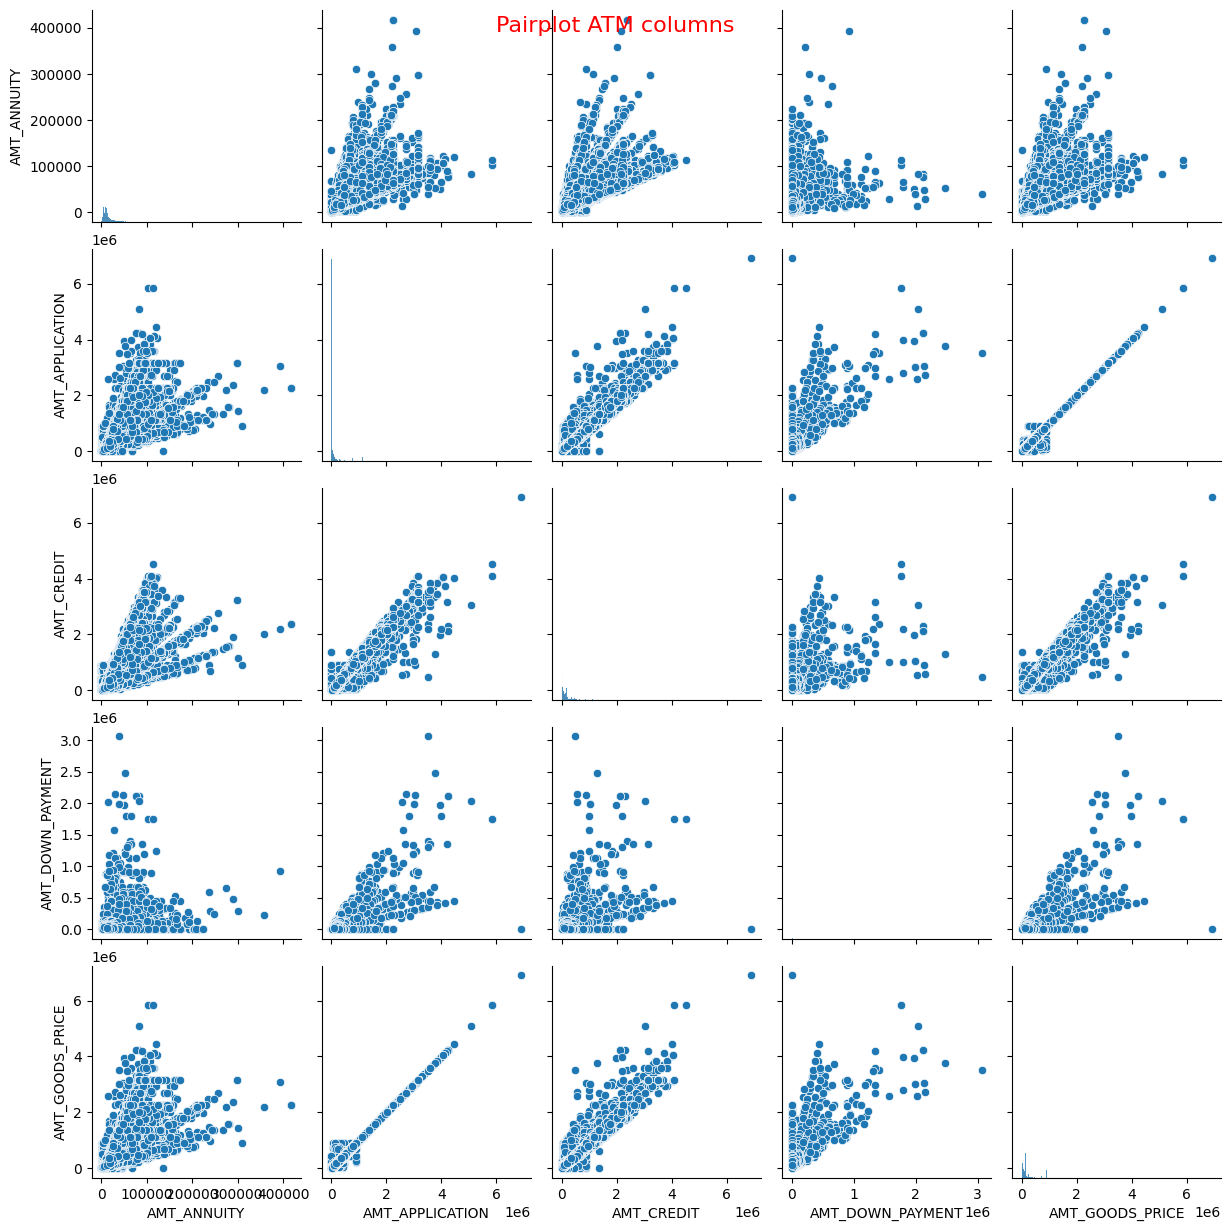

In [39]:
plt.rcParams['figure.figsize'] = 16,8
sns.pairplot(amt_prev_app_df)
plt.suptitle('Pairplot ATM columns', fontsize=16, color='r')
plt.show();

### Trực quan hóa thuộc tính AMT bằng heatmap

In [ ]:
atm_corr = amt_prev_app_df.corr()
mask = np.ones_like(atm_corr, dtype=bool)
# trả vể ma trận tam giác trên
mask = np.triu(mask) 
# bỏ đi dòng đầu tiên và cột cuối cùng để visulization dễ nhìn hơn
mask = mask[1:,:-1]
atm_corr = atm_corr.iloc[1:,:-1]

In [ ]:
plt.rcParams['figure.figsize'] = 16,8
sns.heatmap(atm_corr, mask = mask, annot = True, 
            fmt = '.2f', linecolor = 'white',linewidths=0.6)
plt.title('Heatmap ATM columns', fontsize = 16, color ='r')
plt.show()

**Nhận xét**:
- Nhìn chung các thuộc tính trong cùng nhóm đều có tương quan tuyến tính mạnh với nhau. VD như AMT_GOODS_PRICE và AMT_APPLICATION.
- Ngoại trừ AMT_DOWN_PAYMENTS thì kém tương quan hơn đối với các thuộc tính còn lại trong nhóm

### 1.5.2 DAYS columns

**Mô tả dữ liệu**: gồm các thông tin liên quan đến thời hạn thanh toán của đơn vay.
- `DAYS_DECISION`: bao nhiêu ngày kể từ khi quyết định về đơn vay trước đó được đưa ra. Tất cả các giá trị đều âm vì chúng đại diện cho các sự kiện trong quá khứ.

- `DAYS_TERMINATION`: cho biết bao nhiêu ngày kể từ khi ứng dụng kết thúc. Các giá trị luôn âm, ngoại trừ '365243' có nghĩa là ứng dụng này vẫn đang hoạt động (chưa hoàn tất).

- `DAYS_FIRST_DRAWING`: cho biết bao nhiêu ngày kể từ lần giải ngân đầu tiên của ứng dụng trước đó. 

- `DAYS_LAST_DUE_1ST_VERSION`: có thể có giá trị dương (các sự kiện trong tương lai), điều này thường xảy ra khi khách hàng hoàn thành khoản vay trước thời hạn ban đầu.
    
- `DAYS_LAST_DUE`: liên quan đến ngày nộp đơn khi đến hạn cuối cùng thực sự xảy ra. Nếu đến hạn cuối cùng vẫn chưa được thanh toán, giá trị sẽ là 365243.
    
- `CNT_PAYMENT`: Số lần trả nợ ban đầu.

In [ ]:
days_prev_app_df = prev_app_df[['DAYS_DECISION', 'DAYS_TERMINATION', 'DAYS_FIRST_DRAWING',
                               'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE','CNT_PAYMENT']]
days_prev_app_df.agg([missing_ratio, min, lower_quantile, np.median, upper_quantile, max, np.std])

**Nhận xét**: 
- Khoảng giá trị của các thuộc tính không có gì bất thường, nhưng độ lệch chuẩn cũng tương đối lớn.
- Nhóm sẽ phân tích phân bố của dữ liệu để xác định tồn tại outlier hay không ?
- Nhóm sẽ loại bỏ giá trị 365243 khi phân tích sự phân bố của dữ liệu vì đây là giá trị đặc biệt chứ không phải điểm bất thường.

In [ ]:
fig, ax = plt.subplots(3,3, figsize = (24,15), layout="constrained")
for idx in range(days_prev_app_df.shape[1]):
    r,c = idx // 3, idx % 3 
    transaction_data = days_prev_app_df[days_prev_app_df[days_prev_app_df.columns[idx]] < 365243]
    sns.histplot(transaction_data.iloc[:,idx:idx+1], ax=ax[r,c])
    ax[r,c].set_title(f'Distribution of {days_prev_app_df.columns[idx]}', fontsize = 14, color='r')
    
ax[2,1].set_visible(False)
ax[2,2].set_visible(False)
plt.show()

**Nhận xét**:
- Các thuộc tính đều không tuân theo phân phối chuẩn và khá đa dạng về phân bố. 
- Điểm đặc biệt ở các thuộc tính này là có giá trị 365243, nhóm sẽ phân tích xem giá trị này thường dùng cho `NAME_CONTRACT_TYPE` và `NAME_CONTRACT_STATUS` nào. Để xem phân bố của `NAME_CONTRACT_TYPE` đang diễn ra có cùng phân bố như phần trên mà nhóm đã phân tích.

In [ ]:
_365_prev_app_columns = ['DAYS_TERMINATION', 'DAYS_FIRST_DRAWING',
                         'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION','DAYS_LAST_DUE']

In [ ]:
prev_app_df[prev_app_df[days_prev_app_df.columns[idx]] < 365243]

In [ ]:
fig, ax = plt.subplots(2,3, figsize = (15,10), layout="constrained")
for idx in range(len(_365_prev_app_columns)):
    r,c = idx // 3, idx % 3 
    transaction_data = prev_app_df[(prev_app_df[_365_prev_app_columns[idx]] == 365243)]
    print(f'{_365_prev_app_columns[idx]} có {transaction_data.shape[0]} dòng chứa giá trị "365243"')
    groupby_trans_data = transaction_data.groupby(['NAME_CONTRACT_STATUS', 
                                                   'NAME_CONTRACT_TYPE'])
    groupby_trans_data = groupby_trans_data[[_365_prev_app_columns[idx]]].count()
                                            
    groupby_trans_data.plot(kind='bar', stacked=True, ax = ax[r,c]);
    ax[r,c].set_title(f'Stack barchart of {_365_prev_app_columns[idx]}', fontsize = 14, color='r')
    ax[r,c].tick_params(axis='x', rotation=45)
    
ax[1,2].set_visible(False)
plt.show()

**Nhận xét**:
- Đơn vay toàn bộ có status `Approved`, các đơn có status là `Refused/Canceled/Unused` thì giá trị bị thiếu.  $\rightarrow$ Không có gì bất thường.
- DAYS_TERMINATION và DAYS_LAST_DUE: 
    - Giá trị "365243" phân bố khá đồng đều giữa các loại contract.

- DAYS_FIRST_DRAWING`: 
    - Giá trị "365243" đa số chỉ dành cho `Consumer/Cash loans` .
    
- DAYS_FIRST_DUE và DAYS_LAST_DUE_1ST_VERSION: 
    - Giá trị "365243" đa số dành cho `Revolving loans`. Riêng `DAYS_LAST_DUE_1ST_VERSION` vì chúng thường không có ngày đến hạn cuối cùng cụ thể và do đó, nếu hạn mức tín dụng vẫn còn hiệu lực thì giá trị này có thể là 365243.
    - Đối với `Consumer/Cash loans`, giá trị 365243 chiếm tỷ lệ không cao.

### Trực quan hóa các thuộc tính DAYS bằng Heatmap

In [ ]:
days_corr = days_prev_app_df.corr()
mask = np.ones_like(days_corr, dtype=bool)
# trả vể ma trận tam giác trên
mask = np.triu(mask) 
# bỏ đi dòng đầu tiên và cột cuối cùng để visulization dễ nhìn hơn
mask = mask[1:,:-1]
days_corr = days_corr.iloc[1:,:-1]

In [ ]:
plt.rcParams['figure.figsize'] = 16,8
sns.heatmap(days_corr, mask = mask, annot = True, 
            fmt = '.2f', linecolor = 'white',linewidths=0.6)
plt.title('Heatmap DAYS columns', fontsize = 16, color='r')
plt.show()

**Nhận xét**:
- Nhìn chung các thuộc tính tương quan khá kém với nhau.
- Ngoại trừ DAYS_LAST_DUE vs DAYS_TERMINATION và DAYS_LAST_DUE_1ST_VERSION vs DAYS_FIRST_DRAWING, và một số cặp chỉ có mức độ tương quan trung bình. 

## 1.6 Lựa chọn thuộc tính

**Nhận xét**:
- Các thuộc tính bị thiếu dữ liệu trên 99% như `RATE_INTEREST_PRIMARY` và `RATE_INTEREST_PRIVILEGED`  $\rightarrow$ nhóm sẽ xóa những thuộc tính này.
- Các thuộc tính liên quan đến loại hàng hóa, ngành bán thì nhóm đề xuất sẽ xóa. Có 2 nguyên nhân chính:
    - Dữ liệu thời gian được biểu diễn dưới dạng khoảng thời gian còn lại(đếm ngược) so với giao dịch hiện tại nên không thể biết thời gian cụ thể.
    - Việc không biết thời gian cụ thể sẽ khó để xác định có sự ảnh hưởng của tính xu hướng hay tính chu kỳ lên tập dữ liệu hay không ? Ví dụ, khách vay vốn để mua bất động sản nhưng tình hình bất động sản tại mỗi thời điểm khác nhau nên khả năng thu hồi vốn và trả nợ của khách hàng cũng khác nhau.

<h1 align="center">Current Application Table </h1>

### Mô tả dữ liệu:
- Dữ liệu chính để giải quyết bài toán, với mỗi dòng là một đơn đơn đăng kí vay.
- Dữ liệu được chia thành 2 tập train và test. Sự khác biệt là tập train là tập có các label TARGET được cung cấp sẵn.
- "TARGET" là một biến mục tiêu trong tệp "application_{train|test}.csv", và đại diện cho "biến mục tiêu (1 - khách hàng gặp khó khăn trong thanh toán: anh ta / cô ta đã thanh toán chậm hơn X ngày trên ít nhất một trong Y khoản trả góp đầu tiên của khoản vay trong mẫu của chúng tôi, 0 - tất cả các trường hợp khác)".Trong đó, X là một ngưỡng được thiết lập trước để xác định khoản nợ bị trễ thanh toán, và Y là số lượng khoản trả góp đầu tiên của khoản vay trong mẫu. Ví dụ, nếu X được thiết lập là 30 và Y là 3, thì nếu khách hàng đã thanh toán chậm hơn 30 ngày trên ít nhất một trong 3 khoản trả góp đầu tiên của khoản vay trong mẫu, thì khách hàng sẽ được xem là có khó khăn trong thanh toán và "TARGET" sẽ được đánh dấu là 1. Ngược lại, nếu khách hàng thanh toán đầy đủ và đúng hạn cho tất cả các khoản trả góp đầu tiên của khoản vay trong mẫu, thì "TARGET" sẽ được đánh dấu là 0.
- "TARGET" là biến mục tiêu trong bài toán dự đoán khả năng khách hàng trả nợ và rủi ro tín dụng của khách hàng cho các khoản vay mới.

In [ ]:
app_train = pd.read_csv('Data/application_train.csv')
app_test = pd.read_csv('Data/application_test.csv')
df = pd.concat([app_test, app_train]).reset_index()

## 2.1 Dữ liệu có bao nhiêu dòng, cột


In [ ]:
print(f'Dữ liệu có {df.shape[0]} dòng và {df.shape[1]} cột')

## 2.2 Dữ liệu có bị trùng hay không?

In [ ]:
df.duplicated().sum()

## 2.3 Column Types

In [ ]:
df.dtypes.value_counts()

## 2.4 Dữ liệu có gì bất thường không?

In [ ]:
df.info(verbose=True, show_counts=True)

In [ ]:
for col in df.select_dtypes('O'):
    print(f'Các giá trị của cột categorical {col}')
    print(df[col].unique())
    print('===========================')

## 2.5 Missing Value

In [ ]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [ ]:
missing_values = missing_values_table(df)
missing_values.head(20)

In [ ]:
def print_pct(x):
    return '{:.0f}'.format(x * df.shape[1] / 100)
plt.pie(x=[len(missing_values), df.shape[1] - len(missing_values)], 
        labels=['Số cột missing', ''], autopct=print_pct);
plt.legend();

In [ ]:
miss_than_50 = (missing_values['% of Total Values'] > 50).value_counts()
miss_than_50.rename(index={True: 'Missing > 50%', False: 'Missing < 50%'}, inplace=True)
plt.pie(miss_than_50, labels=miss_than_50.index, autopct="%1.1f%%")
plt.title("Tỉ lệ cột missing.")
plt.show()

**Nhận xét**:
- Có hơn một nữa số cột có các giá trị Nan.
- Ở các cột này có số lượng missing khá nhiều, khi mà số lượng cột có missing lớn hơn 50% chiếm hơn một nữa các cột này.
- Những cột missing top đầu đa số là các cột miêu tả chi tiết về tình hình tải sản của người vay

### `NAME_CONTRACT_TYPE`, `CODE_GENDER`

In [ ]:
figure, axs = plt.subplots(2, 1, figsize=(8, 8))
contract_counts = df['NAME_CONTRACT_TYPE'].value_counts()
code_gender = df['CODE_GENDER'].value_counts()
axs[0].pie(contract_counts, labels=contract_counts.index, autopct='%1.1f%%')
axs[0].legend(title="Loại hợp đồng", loc="best", bbox_to_anchor=(1, 0, 0.5, 1))
axs[1].pie(code_gender, labels=code_gender.index, autopct='%1.1f%%')
axs[1].legend(title="Giới tính người vay", loc="best", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

**Nhận xét**:
- Revolving loans (credit card): Người đi vay được cập một hạn mức tín dụng, người đó có thể chi tiêu/rút tiền với hạn mức tín dụng đó. Và cuối tháng thì ngân hàng sẽ thông báo khoản vay tối thiểu mà người đó phải trả
- Cash loans: Người xin vay được cấp một khoản tiền mặt để có thể chi tiêu và sẽ cần hoàn trả khoản tín dụng đó hàng tháng, mỗi tháng cách nhau 30 ngày. Đa số các khoản vay trong tập dữ liệu là loại này

### `FLAG_OWN_CAR`, `FLAG_OWN_REALITY`

In [ ]:
freq_table = pd.crosstab(df['FLAG_OWN_REALTY'], df['FLAG_OWN_CAR'])
freq_table.plot.bar()
plt.xlabel('Sở hữu bất động sản')
plt.ylabel('Số lượng')
plt.xticks(rotation=0)
plt.show()

In [ ]:
freq_table

**Nhận xét**:
- Trong số 246970 hồ sơ sở hữu bất động sản, có 83733 hồ sơ cũng sở hữu xe hơi (`FLAG_OWN_CAR` = Y), chiếm khoảng 34% tổng số hồ sơ sở hữu bất động sản.
- Trong số  109285 hồ sơ không sở hữu bất động sản, có 37287 hồ sơ sở hữu xe hơi (`FLAG_OWN_CAR` = Y), chiếm khoảng 34% tổng số hồ sơ không sở hữu bất động sản.

Từ kết quả trên, ta có thể kết luận rằng việc sở hữu bất động sản và sở hữu xe hơi không có mối tương quan, tức là người sở hữu bất động sản không có xu hướng sở hữu xe hơi hơn so với người không sở hữu bất động sản. Và tỉ lệ gần như không thay đổi giữa 2 nhóm người.

### `CNT_CHILDREN`, `CNT_FAM_MEMBERS`

In [ ]:
fig = plt.figure(figsize=(11, 6))
children_by_family_members = df.groupby('CNT_FAM_MEMBERS')['CNT_CHILDREN'].value_counts()
children_by_family_members.plot.bar()
idx = children_by_family_members.index
children_by_family_members.index = children_by_family_members.index.set_levels([idx.levels[0].astype('int'),
                                                                                idx.levels[-1]])
ax = plt.gca()
ax.set_xticklabels(children_by_family_members.index, rotation=45, ha='right')
plt.title('Số lượng thành viên và số lượng trẻ em trong gia đình')
plt.show()

**Nhận xét**:
- Hầu hết các gia đình trong dữ liệu đều có từ 1 đến 4 thành viên, với số trẻ em trong gia đình từ 0 đến 3.
- Có một số gia đình lớn hơn, với từ 5 đến 20 thành viên và số trẻ em trong gia đình lên đến 19.
- Số lượng thành viên gia đình không lớn hơn 2 với số lượng trẻ em, vậy người vay không có ảnh hưởng bởi bố mẹ của họ.
- Số lượng (2, 0) nhiều nhất, nghĩa là đa số 3 vợ chồng chưa có con vay chiếm số lượng lớn khách hàng vay

### `AMT_INCOME_TOTAL`, `AMT_CREDIT`, `AMT_ANNUITY`, `AMT_GOODS_PRICE`

In [ ]:
amt = df[['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']]
pd.options.display.float_format = '{:.2f}'.format
amt.describe()

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(12, 15))
for i, col in enumerate(amt.columns):
    axs[i].hist(amt[col], bins=50)
    axs[i].set_title(f'Histogram của {col}')

**Nhận xét**:
- **AMT_ANNUITY**: số tiền phải trả hằng tháng(bao gồm cả lãi). Khách hàng có thể thay đổi Annuity trong `Balance` và `Payments` tables. 
- **AMT_APPLICATION**: khách hàng đã yêu cầu tín dụng bao nhiêu trong lần đăng ký trước tín dụng.
- **AMT_GOODS_PRICE**: giá của hàng hóa mà khách hàng vay để mua.
- **AMT_CREDIT**: số tiền thực tế mà khách hàng nhận được, có thể cao hoặc thấp hơn dựa vào chế độ bảo hiểm hoặc chính sách của Home Credit.
    - AMT_CREDIT = AMT_GOODS_PRICE + tiền bảo hiểm 
    - NFLAG_INSURED_ON_APPROVAL liên quan đến một trong những tùy chon bảo hiểm mà Home Credit cung cấp
- `AMT_INCOME_TOTAL` khả năng cao có outlier vì giá trị max của nó gấp gần 50 lần khoảng 75%
- Các biến số đều có giá trị lớn nhất và nhỏ nhất khác biệt rất lớn, cho thấy sự đa dạng trong dữ liệu và sự khác biệt lớn về khả năng tài chính của các cá nhân trong tập dữ liệu.
- Giá trị trung bình (mean) của biến `AMT_INCOME_TOTAL` thấp hơn giá trị trung bình của biến `AMT_CREDIT` và `AMT_GOODS_PRICE`, cho thấy có một số người có thu nhập thấp hơn so với số tiền vay hoặc giá trị của tài sản mà họ mua bằng số tiền vay. 

In [ ]:
amt['TARGET'] = df['TARGET']
ax = sns.heatmap(amt.corr(), annot=True, cmap='coolwarm')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

**Nhận xét**
- `AMT_CREDIT` và `AMT_GOODS_PRICE` có tương quan dương mạnh với giá trị tương quan là 0.99. Điều này có nghĩa là giá trị của tài sản mua và số tiền vay mượn có mối quan hệ rất mạnh với nhau. Nên chỉ cần một trong 3 thuộc tính này trong bộ dữ liệu
- `AMT_CREDIT` và `AMT_ANNUITY` có tương quan dương mạnh với giá trị tương quan là 0.77. Điều này có nghĩa là khi số tiền vay mượn tăng thì khoản trả hàng tháng cũng tăng, và ngược lại.

### `NAME_TYPE_SUITE`,  `NAME_INCOME_TYPE` , `NAME_EDUCATION_TYPE`, `NAME_FAMILY_STATUS`

In [ ]:
name = df[['NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']]
pd.options.display.float_format = '{:.2f}'.format
name.describe()

- `NAME_TYPE_SUITE`: Đây là thuộc tính mô tả thông tin về người đi cùng với khách hàng khi họ đến nơi đăng ký vay tiền. Ví dụ, người đi cùng có thể là vợ/chồng, người yêu, bố/mẹ hoặc bạn bè. Các giá trị có thể có cho thuộc tính này bao gồm: Unaccompanied (không có ai đi cùng), Spouse/Partner (vợ/chồng hoặc người yêu), Children (con cái), Family (gia đình), Other_A (khác), Other_B (khác), Group of people (nhóm người).
- `NAME_INCOME_TYPE`: Đây là thuộc tính mô tả thông tin về loại thu nhập của khách hàng. Các giá trị có thể có cho thuộc tính này bao gồm: Working (lao động), State servant (công chức), Commercial associate (liên kết thương mại), Pensioner (người hưởng lương hưu), Student (sinh viên), Unemployed (thất nghiệp), Businessman (doanh nhân), Maternity leave (nghỉ thai sản), và khác (Other).
- `NAME_EDUCATION_TYPE`: Đây là thuộc tính mô tả thông tin về trình độ học vấn cao nhất của khách hàng. Các giá trị có thể có cho thuộc tính này bao gồm: Lower secondary (trung học cơ sở), Secondary / secondary special (trung học phổ thông / trung học phổ thông chuyên nghiệp), Incomplete higher (trung học không hoàn thành), Higher education (đại học), Academic degree (học vị).
- `NAME_FAMILY_STATUS`: Đây là thuộc tính mô tả thông tin về tình trạng hôn nhân và gia đình của khách hàng. Các giá trị có thể có cho thuộc tính này bao gồm: Single / not married (độc thân / chưa kết hôn), Married (đã kết hôn), Civil marriage (kết hôn dân sự), Widow (góa phụ), Separated (ly thân / chia tay), và khác (Other).
- `NAME_HOUSING_TYPE`: Đây là thuộc tính mô tả thông tin về tình trạng sở hữu nhà cửa của khách hàng. Các giá trị có thể có cho thuộc tính này bao gồm: House / apartment (nhà / căn hộ), Rented apartment (căn hộ thuê), With parents (sống với bố mẹ), Municipal apartment (căn hộ chung cư), Office apartment (căn hộ văn phòng), Co-op apartment (căn hộ thuộc hợp tác xã).

In [ ]:
figure, axs = plt.subplots(5, 1, subplot_kw=dict(aspect="equal"), figsize=(8, 25))
# min % to show
threshold = 2

temp = name['NAME_TYPE_SUITE'].value_counts()
temp = temp[temp > len(name) * threshold / 100]
temp = pd.concat([temp, pd.Series(data=[len(name) - temp.sum()], index=['Other'])])
axs[0].pie(temp, labels=temp.index, autopct='%1.1f%%')
axs[0].legend(title="NAME_TYPE_SUITE", loc="best", bbox_to_anchor=(3, 0, 0.5, 1))

temp = name['NAME_INCOME_TYPE'].value_counts()
temp = temp[temp > len(name) * threshold / 100]
temp = pd.concat([temp, pd.Series(data=[len(name) - temp.sum()], index=['Other'])])
axs[1].pie(temp, labels=temp.index, autopct='%1.1f%%')
axs[1].legend(title="NAME_INCOME_TYPE", loc="best", bbox_to_anchor=(3, 0, 0.5, 1))


temp = name['NAME_EDUCATION_TYPE'].value_counts()
temp = temp[temp > len(name) * threshold / 100]
temp = pd.concat([temp, pd.Series(data=[len(name) - temp.sum()], index=['Other'])])
axs[2].pie(temp, labels=temp.index, autopct='%1.1f%%')
axs[2].legend(title="NAME_EDUCATION_TYPE", loc="best", bbox_to_anchor=(3, 0, 0.5, 1))

temp = name['NAME_FAMILY_STATUS'].value_counts()
temp = temp[temp > len(name) * threshold / 100]
temp = pd.concat([temp, pd.Series(data=[len(name) - temp.sum()], index=['Other'])])
axs[3].pie(temp, labels=temp.index, autopct='%1.1f%%')
axs[3].legend(title="NAME_FAMILY_STATUS", loc="best", bbox_to_anchor=(3, 0, 0.5, 1))


temp = name['NAME_HOUSING_TYPE'].value_counts()
temp = temp[temp > len(name) * threshold / 100]
temp = pd.concat([temp, pd.Series(data=[len(name) - temp.sum()], index=['Other'])])
axs[4].pie(temp, labels=temp.index, autopct='%1.1f%%')
axs[4].legend(title="NAME_HOUSING_TYPE", loc="best", bbox_to_anchor=(3, 0, 0.5, 1))

plt.show()

**Nhận xét**:

Chúng ta có thể thấy rằng hầu hết các khách hàng trong tập dữ liệu đều không có người đi cùng (Unaccompanied) và hầu hết đều làm việc (Working). Chúng ta cũng có thể thấy rằng hầu hết các khách hàng trong tập dữ liệu đều có học vấn trung cấp/ trung học phổ thông (Secondary / secondary special) và số lượng khách hàng ở các loại hình nhà ở (NAME_HOUSING_TYPE) chủ yếu là nhà / căn hộ (House / apartment).

### `DAYS_BIRTH`, `DAYS_EMPLOYED`,  `DAYS_REGISTRATION`, `DAYS_ID_PUBLISH`, `DAYS_LAST_PHONE_CHANGE`

In [ ]:
days = df[['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE']]
days.sample(5)

- DAYS_BIRTH: Đây là số ngày từ ngày khách hàng được sinh ra đến ngày nộp đơn vay. Cột này cho biết độ tuổi của khách hàng tính bằng ngày. Ví dụ, nếu giá trị trong cột này là -10000, thì khách hàng đó được sinh ra cách đây 10,000 ngày trước ngày nộp đơn vay, tương đương với khoảng 27 năm tuổi.
- DAYS_EMPLOYED: Đây là số ngày từ ngày khách hàng bắt đầu làm việc cho công ty hiện tại của họ đến ngày nộp đơn vay. Cột này cho biết thời gian khách hàng đã làm việc tại công ty hiện tại tính bằng ngày. Chú ý rằng giá trị trong cột này có thể là số âm, nghĩa là khách hàng đã bắt đầu làm việc cho công ty hiện tại trước khi nộp đơn vay.
- DAYS_REGISTRATION: Đây là số ngày từ ngày khách hàng thực hiện thay đổi đăng ký cư trú của họ đến ngày nộp đơn vay. Cột này cho biết thời điểm khách hàng đã thực hiện thay đổi đăng ký cư trú tính bằng ngày. Giá trị âm trong cột này cho thấy khách hàng đã thay đổi đăng ký cư trú trước khi nộp đơn vay.
- DAYS_ID_PUBLISH: Đây là số ngày từ ngày khách hàng thực hiện thay đổi giấy tờ tùy thân (CMND/CCCD) mà họ sử dụng để nộp đơn vay đến ngày nộp đơn vay. Cột này cho biết thời điểm khách hàng đã thực hiện thay đổi giấy tờ tùy thân tính bằng ngày. Giá trị âm trong cột này cho thấy khách hàng đã thay đổi giấy tờ tùy thân trước khi nộp đơn vay.
- DAYS_LAST_PHONE_CHANGE: Đây là số ngày mà khách hàng đã thay đổi số điện thoại trước khi đăng kí khoản vay, thuộc tính này thể hiện một vài yếu tố lo ngại các trường hợp cắt liên lạc với bên cho vay.

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(12, 15))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for i, col in enumerate(days.columns):
    axs[i].hist(days[col], bins=np.linspace(days[col].min(), days[col].max(), 100))
    axs[i].set_title(f'Histogram của {col}')
    axs[i].set_xticks(np.linspace(days[col].min(), days[col].max(), 10))

**Nhận xét**:
- Có giá trị của `DAYS_EMPLOYED` là 365243 days. Dữ liệu này bị sai nên nhóm sẽ thay thế bằng giá trị Nan.
- Chuyển sang đơn vị year để dễ hiểu dữ liệu hơn

In [ ]:
df.DAYS_EMPLOYED.replace({365243: np.nan}, inplace=True)
days.DAYS_EMPLOYED = df.DAYS_EMPLOYED
fig, axs = plt.subplots(5, 1, figsize=(12, 15))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for i, col in enumerate(days.columns):
    axs[i].hist(days[col] / -365, bins=np.linspace(days[col].max() / -365, days[col].min() / -365, 100))
    axs[i].set_title(f'Histogram của {col} (year)')
    axs[i].set_xticks(np.linspace(days[col].max() / -365, days[col].min() / -365, 10))

**Nhận xét**:
- Độ tuổi người vay trong khoảng từ 20 đến 70 tuổi. Có sự gia tăng đột biến ở tuổi 27.
- Hầu hết mọi người vay tiền ngay trong những năm đầu sau khi họ có việc làm. 
- Một số lượng áp đảo khách hàng thay đổi số điện thoại ngay trong ngày đăng kí khoản vay, không rõ đây là dữ liệu sai hay là một việc đặc thù khi vay tiền.

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(12, 15))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for i, col in enumerate(days.columns):
    sns.kdeplot(df.loc[df['TARGET'] == 0, col] / -365, label='targget = 0', ax=axs[i])
    sns.kdeplot(df.loc[df['TARGET'] == 1, col] / -365, label='targget = 1', ax=axs[i])
    axs[i].legend(loc="best")
    axs[i].set_title(f'KDE plot của {col} (years)')

**Nhận xét**:
- Qua các biểu đồ KDE trên, ta thấy đa số các thuộc tính có sự thay đổi độ phân bổ giữa target = 0, và target = 1 gần như bằng nhau qua các giá trị ở trục x. Ngoại trừ thuộc tính độ tuổi khách hàng.
- Với targget = 0, ta thấy thuộc tính `DAYS_OF_BIRTH` phân bố khá chuẩn khi không lệch về bên nào, nhưng với targget = 1 (không có khả năng thanh toán nợ) lại bị lệch về phía những người trẻ.

## Process Data

In [ ]:
# Label Encoding
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1

# One Hot Encoding
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)


# Fix anomalous value
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_test['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])

## Correlations

In [ ]:
correlations = app_train.corr()['TARGET'].sort_values()

print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

## Exterior Sources

EXT_SOURCE_1, EXT_SOURCE_2 và EXT_SOURCE_3, DAYS_BIRTH đều là các biến số đại diện cho các nguồn tín dụng bên ngoài khác nhau và có mức độ tương quan âm mạnh nhất với mục tiêu trong bộ dữ liệu.

In [ ]:
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)
poly_transformer = PolynomialFeatures(degree = 3)

poly_transformer.fit(poly_features)

poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Trong bộ dữ liệu, việc tạo ra các tính năng đa thức có thể tạo ra một số lượng tính năng mới đáng kể, vì chúng được tạo ra bằng cách kết hợp các tính năng hiện có với các hệ số đa thức. Để lấy tên của các tính năng mới này, chúng ta có thể sử dụng phương thức get_feature_names của lớp PolynomialFeatures.

Phương thức này sẽ trả về một danh sách các tên tính năng mới, được đánh số theo thứ tự của các hệ số đa thức tương ứng. Chúng ta có thể sử dụng danh sách này để tìm kiếm các tính năng cụ thể hoặc để thực hiện các phân tích khác trên các tính năng mới này.

In [ ]:
poly_transformer.get_feature_names_out(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

Sau khi tạo ra các tính năng đa thức từ các tính năng hiện có, chúng ta có tổng cộng 35 tính năng mới, bao gồm các tính năng được lũy thừa đến bậc 3 và các tính năng tương tác. Bây giờ, chúng ta có thể kiểm tra xem có bất kỳ tính năng mới nào có liên quan đến mục tiêu không bằng cách xem xét mức độ tương quan giữa từng tính năng mới và mục tiêu

In [ ]:
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                         'EXT_SOURCE_3', 'DAYS_BIRTH']))
poly_features['TARGET'] = poly_target

poly_corrs = poly_features.corr()['TARGET'].sort_values()

print(poly_corrs.head(10))
print(poly_corrs.tail(5))

In [ ]:
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

### DOMAIN KNOWDLEDGE FIELD

- `CREDIT_INCOME_PERCENT`: tỷ lệ phần trăm số tiền vay tín dụng so với thu nhập của khách hàng
- `ANNUITY_INCOME_PERCENT`: tỷ lệ phần trăm số tiền trả góp hàng tháng của khoản vay so với thu nhập của khách hàng
- `CREDIT_TERM`: thời hạn trả nợ trong số tháng (vì khoản trả hàng tháng là số tiền trả góp)
- `DAYS_EMPLOYED_PERCENT`: tỷ lệ phần trăm số ngày làm việc so với tuổi của khách hàng

In [ ]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

plt.figure(figsize = (12, 20))
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    plt.subplot(4, 1, i + 1)
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    plt.legend()
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
plt.tight_layout(h_pad = 2.5)

## Feature Final

**Nhận xét**:
Dựa vào tham khảo trên kaggle và nghiên cứu, nhóm tìm thấy 2 cách phù hợp để trích xuất dữ liệu:
- *Polynomial Features*
    - Các biến được tạo bằng cách nâng số mũ của một số biế hiện có, biến mới này có thể đại diện cho các biến tạo thành nó.
    - Trong khi bản thân các biến có thể không có ảnh hưởng mạnh đến TARGET, nhưng việc kết hợp chúng lại với nhau thành một biến tương tác duy nhất có thể cho thấy mối quan hệ với biến TARGET.
    - Ví dụ: có thể tạo 1 biến đại diện cho 2 biến ``
    - Khi tạo các Polynomial Feature nên tránh sử dụng bậc quá cao, vì số lượng đặc trưng tỷ lệ theo cấp số nhân và có thể dẫn tới overfitting.

## Integration cur_app and prev_app

In [178]:
def get_apps_processed(apps):
    """
    feature engineering for apps
    """

    # 1.EXT_SOURCE_X FEATURE 
    apps['APPS_EXT_SOURCE_MEAN'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
    apps['APPS_EXT_SOURCE_STD'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    apps['APPS_EXT_SOURCE_STD'] = apps['APPS_EXT_SOURCE_STD'].fillna(apps['APPS_EXT_SOURCE_STD'].mean())
    
    # AMT_CREDIT 
    apps['APPS_ANNUITY_CREDIT_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_CREDIT']
    apps['APPS_GOODS_CREDIT_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_CREDIT']
    
    # AMT_INCOME_TOTAL 
    apps['APPS_ANNUITY_INCOME_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CREDIT_INCOME_RATIO'] = apps['AMT_CREDIT']/apps['AMT_INCOME_TOTAL']
    apps['APPS_GOODS_INCOME_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CNT_FAM_INCOME_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['CNT_FAM_MEMBERS']
    
    # DAYS_BIRTH, DAYS_EMPLOYED 
    apps['APPS_EMPLOYED_BIRTH_RATIO'] = apps['DAYS_EMPLOYED']/apps['DAYS_BIRTH']
    apps['APPS_INCOME_EMPLOYED_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_EMPLOYED']
    apps['APPS_INCOME_BIRTH_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_BIRTH']
    apps['APPS_CAR_BIRTH_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_BIRTH']
    apps['APPS_CAR_EMPLOYED_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_EMPLOYED']
    
    return apps

In [198]:
def get_prev_processed(prev):
    """
    feature engineering 
    for previouse application credit history
    """
    prev['PREV_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
    prev['PREV_GOODS_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_GOODS_PRICE']
    prev['PREV_CREDIT_APPL_RATIO'] = prev['AMT_CREDIT']/prev['AMT_APPLICATION']
    # prev['PREV_ANNUITY_APPL_RATIO'] = prev['AMT_ANNUITY']/prev['AMT_APPLICATION']
    prev['PREV_GOODS_APPL_RATIO'] = prev['AMT_GOODS_PRICE']/prev['AMT_APPLICATION']

    # Data Cleansing
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.na, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.na, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.na, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.na, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.na, inplace= True)

    # substraction between DAYS_LAST_DUE_1ST_VERSION and DAYS_LAST_DUE
    prev['PREV_DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']

    # 1.Calculate the interest rate
    all_pay = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
    prev['PREV_INTERESTS_RATE'] = (all_pay/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']

    return prev

def get_prev_amt_agg(prev):
    """
    feature engineering for the previous credit appliction
    """

    agg_dict = {
      'SK_ID_CURR':['count'],
      'AMT_CREDIT':['mean', 'max', 'sum'],
      'AMT_ANNUITY':['mean', 'max', 'sum'], 
      'AMT_APPLICATION':['mean', 'max', 'sum'],
      'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
      'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
      'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
      'DAYS_DECISION': ['min', 'max', 'mean'],
      'CNT_PAYMENT': ['mean', 'sum'],
        
      'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
      'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
      'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
      'PREV_GOODS_APPL_RATIO':['mean', 'max'],
      'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
      'PREV_INTERESTS_RATE':['mean', 'max']
    }

    prev_group = prev.groupby('SK_ID_CURR')
    prev_amt_agg = prev_group.agg(agg_dict)

    # multi index 
    prev_amt_agg.columns = ["PREV_"+ "_".join(x).upper() for x in prev_amt_agg.columns.ravel()]

    return prev_amt_agg

def get_prev_refused_appr_agg(prev):
    """
    PREV_APPROVED_COUNT : Credit application approved count
    PREV_REFUSED_COUNT :  Credit application refused count
    """
    prev_refused_appr_group = prev[prev['NAME_CONTRACT_STATUS'].isin(['Approved', 'Refused'])].groupby([ 'SK_ID_CURR', 'NAME_CONTRACT_STATUS'])
    # unstack() 
    prev_refused_appr_agg = prev_refused_appr_group['SK_ID_CURR'].count().unstack()

    # rename column 
    prev_refused_appr_agg.columns = ['PREV_APPROVED_COUNT', 'PREV_REFUSED_COUNT' ]

    # NaN
    prev_refused_appr_agg = prev_refused_appr_agg.fillna(0)

    return prev_refused_appr_agg

# DAYS_DECISION
def get_prev_days365_agg(prev):
    """
    DAYS_DESCISION means How many days have been take since the previous credit application made.
    Somehow this feature is important.
    """
    cond_days365 = prev['DAYS_DECISION'] > -365
    prev_days365_group = prev[cond_days365].groupby('SK_ID_CURR')
    agg_dict = {
      'SK_ID_CURR':['count'],
      'AMT_CREDIT':['mean', 'max', 'sum'],
      'AMT_ANNUITY':['mean', 'max', 'sum'], 
      'AMT_APPLICATION':['mean', 'max', 'sum'],
      'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
      'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
      'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
      'DAYS_DECISION': ['min', 'max', 'mean'],
      'CNT_PAYMENT': ['mean', 'sum'],
      
      'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
      'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
      'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
      'PREV_GOODS_APPL_RATIO':['mean', 'max'],
      'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
      'PREV_INTERESTS_RATE':['mean', 'max']
    }

    prev_days365_agg = prev_days365_group.agg(agg_dict)

    # multi index 
    prev_days365_agg.columns = ["PREV_D365_"+ "_".join(x).upper() for x in prev_days365_agg.columns.ravel()]

    return prev_days365_agg

def get_prev_agg(prev):
    prev = get_prev_processed(prev)
    prev_amt_agg = get_prev_amt_agg(prev)
    prev_refused_appr_agg = get_prev_refused_appr_agg(prev)
    prev_days365_agg = get_prev_days365_agg(prev)
    
    # prev_amt_agg
    prev_agg = prev_amt_agg.merge(prev_refused_appr_agg, on='SK_ID_CURR', how='left')
    prev_agg = prev_agg.merge(prev_days365_agg, on='SK_ID_CURR', how='left')
    # SK_ID_CURR APPROVED_COUNT REFUSED_COUNT
    prev_agg['PREV_REFUSED_RATIO'] = prev_agg['PREV_REFUSED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    prev_agg['PREV_APPROVED_RATIO'] = prev_agg['PREV_APPROVED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    # 'PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT' drop 
    prev_agg = prev_agg.drop(['PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT'], axis=1)
    
    return prev_agg

In [ ]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

In [166]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1025**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [171]:
def get_dataset():
    app_train = pd.read_csv(os.path.join(default_dir,'application_train.csv'))
    app_train = reduce_mem_usage(app_train)
    app_test = pd.read_csv(os.path.join(default_dir,'application_test.csv'))
    app_test = reduce_mem_usage(app_test)
    apps = pd.concat([app_train, app_test])
    prev = pd.read_csv(os.path.join(default_dir,'previous_application.csv'))
    prev = reduce_mem_usage(prev)

    return apps, prev

apps, prev = get_dataset()

Memory usage after optimization is: 92.38 MB
Decreased by 67.7%
Memory usage after optimization is: 14.60 MB
Decreased by 67.6%
Memory usage after optimization is: 309.01 MB
Decreased by 34.5%


In [173]:
def get_apps_all_with_prev_agg(apps, prev):
    apps_all =  get_apps_processed(apps)
    prev_agg = get_prev_agg(prev)
    print('prev_agg shape:', prev_agg.shape)
    print('apps_all before merge shape:', apps_all.shape)
    apps_all = apps_all.merge(prev_agg, on='SK_ID_CURR', how='left')
    print('apps_all after merge with prev_agg shape:', apps_all.shape)
    
    return apps_all

def get_apps_all_encoded(apps_all):
    object_columns = apps_all.dtypes[apps_all.dtypes == 'object'].index.tolist()
    for column in object_columns:
        apps_all[column] = pd.factorize(apps_all[column])[0]
    
    return apps_all

In [176]:
def get_apps_all_train_test(apps_all):
    apps_all_train = apps_all[~apps_all['TARGET'].isnull()]
    apps_all_test = apps_all[apps_all['TARGET'].isnull()]

    apps_all_test = apps_all_test.drop('TARGET', axis=1)
    
    return apps_all_train, apps_all_test

In [191]:
apps_all = get_apps_all_with_all_agg(apps, prev)

prev_agg shape: (338857, 80)
apps_all after merge with all shape: (356255, 215)


In [192]:
apps_all = get_apps_all_encoded(apps_all)

apps_all_train, apps_all_test = get_apps_all_train_test(apps_all)
del df, app_train, app_test

In [193]:
ftr_app = apps_all_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
target_app = apps_all_train['TARGET']

train_x, valid_x, train_y, valid_y = train_test_split(ftr_app, target_app, test_size=0.2, random_state=2020)

## Imbalance target

- Mã giả thôi nghe vì t chưa đánh giá được data sau khi merge như nào

In [209]:
X

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,...,PREV_PREV_GOODS_DIFF_MAX,PREV_PREV_GOODS_DIFF_SUM,PREV_PREV_GOODS_APPL_RATIO_MEAN,PREV_PREV_GOODS_APPL_RATIO_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_MEAN,PREV_PREV_DAYS_LAST_DUE_DIFF_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_SUM,PREV_PREV_INTERESTS_RATE_MEAN,PREV_PREV_INTERESTS_RATE_MAX,PREV_D365_SK_ID_CURR_COUNT,PREV_D365_AMT_CREDIT_MEAN,PREV_D365_AMT_CREDIT_MAX,PREV_D365_AMT_CREDIT_SUM,PREV_D365_AMT_ANNUITY_MEAN,PREV_D365_AMT_ANNUITY_MAX,PREV_D365_AMT_ANNUITY_SUM,PREV_D365_AMT_APPLICATION_MEAN,PREV_D365_AMT_APPLICATION_MAX,PREV_D365_AMT_APPLICATION_SUM,PREV_D365_AMT_DOWN_PAYMENT_MEAN,PREV_D365_AMT_DOWN_PAYMENT_MAX,PREV_D365_AMT_DOWN_PAYMENT_SUM,PREV_D365_AMT_GOODS_PRICE_MEAN,PREV_D365_AMT_GOODS_PRICE_MAX,PREV_D365_AMT_GOODS_PRICE_SUM,PREV_D365_RATE_DOWN_PAYMENT_MIN,PREV_D365_RATE_DOWN_PAYMENT_MAX,PREV_D365_RATE_DOWN_PAYMENT_MEAN,PREV_D365_DAYS_DECISION_MIN,PREV_D365_DAYS_DECISION_MAX,PREV_D365_DAYS_DECISION_MEAN,PREV_D365_CNT_PAYMENT_MEAN,PREV_D365_CNT_PAYMENT_SUM,PREV_D365_PREV_CREDIT_DIFF_MEAN,PREV_D365_PREV_CREDIT_DIFF_MAX,PREV_D365_PREV_CREDIT_DIFF_SUM,PREV_D365_PREV_CREDIT_APPL_RATIO_MEAN,PREV_D365_PREV_CREDIT_APPL_RATIO_MAX,PREV_D365_PREV_GOODS_DIFF_MEAN,PREV_D365_PREV_GOODS_DIFF_MAX,PREV_D365_PREV_GOODS_DIFF_SUM,PREV_D365_PREV_GOODS_APPL_RATIO_MEAN,PREV_D365_PREV_GOODS_APPL_RATIO_MAX,PREV_D365_PREV_DAYS_LAST_DUE_DIFF_MEAN,PREV_D365_PREV_DAYS_LAST_DUE_DIFF_MAX,PREV_D365_PREV_DAYS_LAST_DUE_DIFF_SUM,PREV_D365_PREV_INTERESTS_RATE_MEAN,PREV_D365_PREV_INTERESTS_RATE_MAX,PREV_REFUSED_RATIO,PREV_APPROVED_RATIO
0,100002,0,0,0,0,0,"202,500.00","406,597.50","24,700.50","351,000.00",0,0,0,0,0,0.02,-9461,-637,"-3,648.00",-2120,NaN,1,1,0,1,1,0,0,1.00,2,2,0,10,0,0,0,0,0,0,0,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.01,0.00,0.07,...,0.00,0.00,1.00,1.00,150.00,150.00,150.00,0.01,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1.00
1,100003,0,1,0,1,0,"270,000.00","1,293,502.50","35,698.50","1,129,500.00",1,1,1,1,0,0.00,-16765,-1188,"-1,186.00",-291,NaN,1,1,0,1,1,0,1,2.00,1,1,1,11,0,0,0,0,0,0,1,0.31,0.62,NaN,0.10,0.05,0.98,0.80,0.06,0.08,0.03,...,0.00,0.00,1.00,1.00,50.00,150.00,150.00,0.02,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1.00
2,100004,1,0,1,0,0,"67,500.00","135,000.00","6,750.00","135,000.00",0,0,0,0,0,0.01,-19046,-225,"-4,260.00",-2531,26.00,1,1,1,1,1,0,0,1.00,2,2,1,9,0,0,0,0,0,0,2,NaN,0.56,0.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,1.00,1.00,30.00,30.00,30.00,0.02,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1.00
3,100006,0,1,0,0,0,"135,000.00","312,682.50","29,686.50","297,000.00",0,0,0,2,0,0.01,-19005,-3039,"-9,832.00",-2437,NaN,1,1,0,1,0,0,0,2.00,2,2,0,17,0,0,0,0,0,0,0,NaN,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,1.00,1.00,810.00,"1,410.00","1,620.00",NaN,0.03,7.00,"302,792.16","906,615.00","2,119,545.00","24,867.4

In [204]:
X = apps_all_train.drop(columns = ["TARGET"])
y = apps_all_train['TARGET']

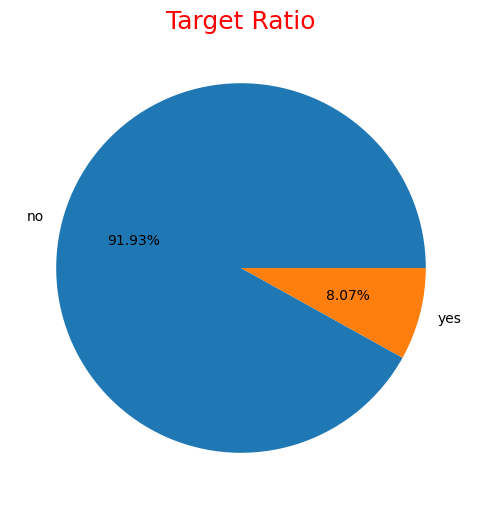

In [205]:
# visualization
plt.rcParams['figure.figsize'] = 12, 6
ax = y.value_counts().plot.pie(labels = ['no', 'yes'], autopct='%.2f%%')
plt.title('Target Ratio', fontsize = 18, color = 'red')
ax.yaxis.set_visible(False)
plt.show()

In [206]:
from imblearn.over_sampling import SMOTE

In [207]:
# SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X,y)

ValueError: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# visualization
plt.rcParams['figure.figsize'] = 12, 6
ax = y_smote.value_counts().plot.pie(labels = ['no', 'yes'], autopct='%.2f%%')
plt.title('Resampling Target Ratio', fontsize = 18, color = 'red')
ax.yaxis.set_visible(False)
plt.show()

In [ ]:
clf = LGBMClassifier(
            nthread=4,
            n_estimators=2000,
            learning_rate=0.02,
            max_depth = 11,
            num_leaves=58,
            colsample_bytree=0.613,
            subsample=0.708,
            max_bin=407,
            reg_alpha=3.564,
            reg_lambda=4.930,
            min_child_weight= 6,
            min_child_samples=165,
            silent=-1,
            verbose=-1,
            )
clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc', verbose= 100, 
            early_stopping_rounds= 200)


## Retrain model

In [82]:
poly_features_names = list(app_train_poly.columns)

poly_features = imputer.fit_transform(app_train_poly)
poly_features_test = imputer.transform(app_test_poly)

poly_features = scaler.fit_transform(poly_features)
poly_features_test = scaler.transform(poly_features_test)

random_forest_poly = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

# Train on the training data
random_forest_poly.fit(poly_features, train_labels)

# Make predictions on the test data
predictions = random_forest_poly.predict_proba(poly_features_test)[:, 1]

# Make a submission dataframe
submit = app_test[['SK_ID_CURR']].copy()
submit.loc[:, 'TARGET'] = predictions

submit.head()

# Save the submission dataframe
submit.to_csv('random_forest_baseline_engineered.csv', index = False)



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.7s finished


In [85]:
scores = cross_val_score(random_forest_poly, poly_features, train_labels, cv=5, scoring='roc_auc')
print('Cross-validation scores: ', scores)
print('Average score: ', np.mean(scores))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]:

Cross-validation scores:  [0.71151366 0.71162912 0.70854219 0.71317813 0.71336152]
Average score:  0.7116449237982956


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished
